In [1]:
# torch.ones(5,device="cuda")
import platform
platform.platform()

'macOS-14.6.1-arm64-arm-64bit'

In [2]:
import numpy as np
import pandas as pd
import torch as torch
import torch.nn as nn
from tqdm import tqdm
from transformers import GPT2Config, GPT2Model
from random import choices, Random, sample, random
from random import seed as randomseed
from matplotlib import pyplot as plt
import torch.nn.functional as F
import time
import math
import copy
# device = torch.device('mps' if torch.backends.mps.is_built() else 'cpu')
device = 'cpu'
print(f'Using device: {device}') # I've only been using CPU so far (and it works fine for the most part, there might be device issues if you use a GPU)

/Users/admin/.pyenv/versions/3.10.6/envs/mem-vs-learn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


### Stationary Distribution method tests

In [4]:
# test convergence of matrix power stationary distribution to eigenvector calculations

# get time for evec, run power iteration and matrix power on a while loop with time 
def timed_evec_stationary(probs):
    '''
    Calculate stationary distribution by calculating the eigenvector with eigenvalue 1
    '''
    start_time = time.time()
    evals, evecs = torch.linalg.eig(probs.mT)
    evec1 = evecs[range(len(evecs)),:, torch.argmax(evals.real, dim=1).squeeze()]
    stationary = (evec1.T / evec1.sum(axis=1)).T
    #eigs finds complex eigenvalues and eigenvectors, so you'll want the real part.
    end_time = time.time()
    elapsed = end_time - start_time
    return stationary.real, elapsed

# run for multiple, check if all distances greater than some value. distances will be an array. plot for multiple runs in the same place, vs different methods
# this probably aint it
def timed_power_iter_stationary(probs, gt, tol=1e-5):
    '''
    Calculate stationary distribution by power iteration (matrix vector multiplication, see https://en.wikipedia.org/wiki/Power_iteration) 
    Iterate until every vector within tol of corresp gt vector

    probs: (nmatrices, nsymb, nsymb) batch of transition matrices (rows are distrs)
    gt:    (nmatrices, 1, nsymb) batch of ground truth stationary distributions (from evec method)

    Return: 
    vecs (nmats, 1, nsymb)
    elapsed time
    dists_over_time (timesteps, nmats) array of distances of vectors from gt with time
    '''
    dists_over_time = []
    start_time = time.time()
    vecs = torch.rand(probs.shape[0], probs.shape[1]).unsqueeze(1) # (nmats, 1, nsymb)
    distances = torch.linalg.vector_norm(vecs-gt, dim=-1).squeeze(-1)
    while torch.any(distances > tol):
        vecs = torch.bmm(vecs, probs) # (nmats, 1, nsymb) @ (nmats, nsymb, nsymb) -> (nmats, 1, nsymb)
        vecs = F.normalize(vecs, p=2, dim=-1)
        distances = torch.linalg.vector_norm(vecs-gt, dim=-1).squeeze(-1) # (nmats,)
        dists_over_time.append(distances)
    end_time = time.time()
    elapsed = end_time - start_time
    dists_over_time = torch.stack(dists_over_time, dim=1)
    return vecs, elapsed, dists_over_time


def timed_matrix_power_stationary(probs, gt, tol=1e-5):
    '''
    Calculate stationary distribution by taking powers of matrices and retrieving any row of the matrix power
    Iterate until every vector within tol of corresp gt vector

    Return: 
    vecs (nmats, 1, nsymb)
    elapsed time
    dists_over_time (timesteps, nmats) array of distances of vectors from gt with time
    '''
    dists_over_time = []
    start_time = time.time()
    powered = probs
    vecs = powered[:, -1, :].unsqueeze(1) # (nmats, 1, nsymb)
    distances = torch.linalg.vector_norm(vecs-gt, dim=-1).squeeze(-1)
    while torch.any(distances > tol):
        print(distances)
        powered = torch.bmm(powered, powered)  # (nmats, nsymb, nsymb) @ (nmats, nsymb, nsymb)
        vecs = powered[:, -1, :].unsqueeze(1)
        distances = torch.linalg.vector_norm(vecs-gt, dim=-1).squeeze(-1)
        dists_over_time.append(distances)
    end_time = time.time()
    elapsed = end_time - start_time
    dists_over_time = torch.stack(dists_over_time, dim=1)
    return vecs, elapsed, dists_over_time


In [5]:
# various methods for calculating stationary distribution

def evec_stationary(prob):
    evals, evecs = torch.linalg.eig(prob.mT)
    # evec1 = evecs[torch.isclose(evals, torch.ones(1, dtype=torch.complex64)),:]
    #Since np.isclose will return an array, we've indexed with an array
    #so we still have our 2nd axis.  Get rid of it, since it's only size 1.
    #  evec1 = evec1[...,0].real
    evec1 = evecs[range(len(evecs)),:, torch.argmax(evals.real, dim=1).squeeze()]
    stationary = (evec1.T / evec1.sum(axis=1)).T
    # print(stationary)

    #eigs finds complex eigenvalues and eigenvectors, so you'll want the real part.
    return stationary.real

def mpow_stationary(prob):
    power = int(2**np.ceil(np.log2(num_symbols*5)))
    return torch.linalg.matrix_power(prob.mT, power)[:,-1]

def manual_stationary(probs, iters=3):
    '''
    Calculate stationary distribution by taking powers of matrices and retrieving any row of the matrix power
    Iterate until every vector within tol of corresp gt vector

    Return: 
    vecs (nmats, 1, nsymb)
    elapsed time
    dists_over_time (timesteps, nmats) array of distances of vectors from gt with time
    '''
    powered = probs
    for i in range(iters):
        powered = torch.bmm(powered, powered)  # (nmats, nsymb, nsymb) @ (nmats, nsymb, nsymb)
    vecs = powered[:, -1, :].squeeze(1)
    return vecs

In [6]:
# verify that ezra's matrix power implementation approximates true eigenvectors\
num_symbols = 3
num_samples = 100
dirichlet = torch.distributions.dirichlet.Dirichlet(torch.ones((num_symbols,num_symbols), device = device))
probs = dirichlet.sample([num_samples])
gts, _ = timed_evec_stationary(probs)

mpow_evecs = mpow_stationary(probs)
manual_evecs = manual_stationary(probs)

mpow_distances = torch.linalg.vector_norm(gts-mpow_evecs, dim=-1)
print(f'Average norm of differences for torch matrix power function: {torch.mean(mpow_distances)}')
print(mpow_distances)

manual_distances = torch.linalg.vector_norm(gts-manual_evecs, dim=-1)
print(f'Average norm of differences for manual matrix power: {torch.mean(manual_distances)}')
print(manual_distances)

Average norm of differences for torch matrix power function: 0.3272150456905365
tensor([0.2220, 0.2636, 0.6778, 0.6565, 0.1129, 0.5095, 0.3702, 0.1188, 0.3555,
        0.5552, 0.3362, 0.3846, 0.2140, 0.1650, 0.5362, 0.4495, 0.1168, 0.8265,
        0.4330, 0.2713, 0.7255, 0.5439, 0.5471, 0.1467, 0.2571, 0.1339, 0.2606,
        0.6587, 0.3103, 0.7662, 0.2151, 0.1673, 0.1193, 0.2379, 0.2783, 0.2874,
        0.4917, 0.1237, 0.5390, 0.4711, 0.4088, 0.3611, 0.1709, 0.1862, 0.1542,
        0.1841, 0.3044, 0.5306, 0.2472, 0.1620, 0.9684, 0.3252, 0.2263, 0.1868,
        0.2258, 0.0552, 0.5089, 0.2378, 0.5322, 0.0836, 0.1128, 0.0088, 0.2518,
        0.5068, 0.2123, 0.4792, 0.2907, 0.3147, 0.3914, 0.0986, 0.1032, 0.1308,
        0.2990, 0.0835, 0.2314, 0.2697, 0.0330, 0.3674, 0.3267, 0.1508, 0.4950,
        0.4569, 0.1461, 0.6494, 0.5701, 0.2213, 0.4737, 0.2265, 0.2610, 0.5457,
        0.1077, 0.4580, 0.3690, 0.2834, 0.5386, 0.2445, 0.3884, 0.2102, 0.2857,
        0.2122])
Average norm of differe

In [7]:
# speed tests
num_symbols = 10
num_samples = 2000
dirichlet = torch.distributions.dirichlet.Dirichlet(torch.ones((num_symbols,num_symbols), device = device))
iters = 2000
# evec
# evec_start_time = time.time()
# for i in range(iters):
#     probs = dirichlet.sample([num_samples])
#     _ = evec_stationary(probs)
# evec_end_time = time.time()
# evec_elapsed = evec_end_time-evec_start_time


mpow_total = 0
manual_total = 0
for i in range(iters):
    probs = dirichlet.sample([num_samples])
    

    # ezra's matrix power
    mpow_start_time = time.time()
    _ = mpow_stationary(probs)
    mpow_end_time = time.time()
    mpow_elapsed = mpow_end_time-mpow_start_time
    mpow_total += mpow_elapsed

    # manual matrix power
    manual_start_time = time.time()
    _ = manual_stationary(probs)
    manual_end_time = time.time()
    manual_elapsed = manual_end_time-manual_start_time
    manual_total += manual_elapsed

# print(f'Evec time: {evec_elapsed}')
print(f'For {iters} calculations of {num_samples} stationary distrs for MCs with {num_symbols} symbols:')
print(f'Matrix Power time: {mpow_total}')
print(f'Manual Matrix Power time: {manual_total}')

KeyboardInterrupt: 

### All other methods

In [3]:
# TODO put num_symbols inside of the main training loop and parametrize these functions with it
num_symbols = 3

# generator for getting uniformly random transition matrices
# dirichlet_markov_ensemble.sample([n]) returns a tensor of n uniformly random num_symbols x num_symbols transition matrices
dirichlet_markov_ensemble = torch.distributions.dirichlet.Dirichlet(torch.ones((num_symbols,num_symbols), device = device))


# faster method of finding stationary distribution of a markov chain, technically an approximation, and I haven't tested for many different number of symbols. Robust method commented out below
# def stationary_distribution(prob):
#     power = int(2**np.ceil(np.log2(num_symbols*5)))
#     return torch.linalg.matrix_power(prob.mT, power)[:,-1]
# only for the stationary_distribution function, chosen a bit arbitrarily

def stationary_distribution(probs, iters=3):
    '''
    Calculate stationary distribution by taking powers of matrices and retrieving any row of the matrix power
    Iterate until every vector within tol of corresp gt vector

    probs is either a single transition matrix (nsymbols, nsymbols) or a batch of them (nmatrices, nsymbols, nsymbols)

    Return: 
    vecs (nmats, 1, nsymb)
    elapsed time
    dists_over_time (timesteps, nmats) array of distances of vectors from gt with time
    '''
    batched_flag = (len(probs.shape) > 2)
    powered = probs
    for _ in range(iters):
        if batched_flag:
            powered = torch.bmm(powered, powered)  # (nmats, nsymb, nsymb) @ (nmats, nsymb, nsymb)
        else:
            powered = powered @ powered
    vecs = powered[:, -1, :].squeeze(1) if batched_flag else powered[-1, :]
    return vecs

# def stationary_distribution(prob):
#     evals, evecs = torch.linalg.eig(prob.mT)
#     # evec1 = evecs[torch.isclose(evals, torch.ones(1, dtype=torch.complex64)),:]
#     #Since np.isclose will return an array, we've indexed with an array
#     #so we still have our 2nd axis.  Get rid of it, since it's only size 1.
#     #  evec1 = evec1[...,0].real
#     evec1 = evecs[range(len(evecs)),:, torch.argmax(evals.real, dim=1).squeeze()]
#     stationary = (evec1.T / evec1.sum(axis=1)).T
#     # print(stationary)

#     #eigs finds complex eigenvalues and eigenvectors, so you'll want the real part.
#     return stationary.real


def data_gen(length, num_symbols, transition_matrices=None):
    '''
    Samples autoregressively from markov chains for `length` symbols. First symbol sampled from stationary distribution; symbols start from 0. if transition_matrices is an integer, then that many uniformly random ones are sampled.

    `num_symbols` specifies the 'vocabulary size' for the data being generated
    '''
    
    if num_symbols is None:
        if transition_matrices is None:
            raise Exception("Expected at least one of `num_symbols`, `transition_matrices`")
    else:
        dirichlet_markov_ensemble = torch.distributions.dirichlet.Dirichlet(torch.ones((num_symbols,num_symbols), device = device))
        if transition_matrices is None:
            transition_matrices = dirichlet_markov_ensemble.sample([64])
        elif type(transition_matrices) is int:
            transition_matrices = dirichlet_markov_ensemble.sample([transition_matrices])
        else:
            pass # if a batch of transition matrices is provided, ignore num_symbols/dirichlet_markov_ensemble
    
    stat_dists = stationary_distribution(transition_matrices)
    # assert torch.isclose(stat_dists, stationary_distribution_old(transition_matrices)).all() 
    # thresholds = transition_matrices.cumsum(axis = 2).tolist()
    num_symbols = transition_matrices.shape[-1]
    output = torch.zeros(len(transition_matrices), length, dtype=int, device = device)
    output[:, 0] = torch.multinomial(stat_dists, 1).squeeze()
    cons = torch.arange(len(transition_matrices), device = device) * num_symbols
    for ind in range(1, length):
        temp = transition_matrices.flatten(end_dim=1)[cons + output[:,ind-1]]
        output[:,ind] = torch.multinomial(temp,1).squeeze()
    return output.to(device)


def data_gen_fixed(length, fixed, num, uniques=None, sequence_sample_probs=None, offset=0):
    '''
    Sample `num` MC sequences of length `length` from fixed distribution `fixed`.

    `uniques` determines the number of unique sequences (for pure memorization task), and can be None, an int, a list/np array, or a tensor of unique sequences. possible inputs for `uniques` are:
        - None: every sequence is a new sample from the fixed MC. 
        - int: this many unique sequences are sampled from fixed, and sample from this set with replacement according to probabilities given by `sequence_sample_probs` (uniformly if `sequence_sample_probs` is None)
        - torch.Tensor of the unique sequences (each row is a unique sequence): ignores fixed and offset, and samples rows from this tensor with probabilities given by `sequence_sample_probs` (uniformly if `sequence_sample_probs` is None). Note: if using separate tokens for fixed and ICL tasks, then these the inputs should already be offset by the appropriate amount; make sure this is done
    Note: it's safe to supply fixed to the method even if uniques is used, as it just gets ignored

    `sequence_sample_probs`: a list or numpy array of probabilities summing to 1. must match uniques; see above.

    `offset` is added to every value in output to allow using separate tokens for fixed vs random MC data. 

    Return: (num, length) array of longs, each row is a sequence
    '''
    unique_sequences = None
    if num == 0: # return empty tensor if told to produce 0 data points
        return torch.zeros((0, length)).long().to(device), unique_sequences, sequence_sample_probs
    
    if fixed is not None: 
        stat_dist = stationary_distribution(fixed)
    if uniques is None: # every sequence is drawn anew, expects fixed to be provided
        output = torch.zeros(num, length, dtype=int, device = device)
        output[:, 0] = torch.multinomial(stat_dist, num, replacement=True).squeeze()
        for ind in range(1, length):
            temp = fixed[output[:,ind-1]] # use most recent state to index rows of transition matrix
            output[:,ind] = torch.multinomial(temp,1).squeeze() # sample new states for each sequence using these rows
        output += offset
    else: # draw a fixed number of unique sequences from fixed, and sample from these with replacement
        # get unique sequences
        if isinstance(uniques, int): 
            assert uniques >= 1, "uniques must be >=1 if an integer"
            num_unique_sequences = uniques
            # generate the unique sequences
            unique_sequences = torch.zeros(num_unique_sequences, length, dtype=int, device=device)
            unique_sequences[:, 0] = torch.multinomial(stat_dist, num_samples=num_unique_sequences, replacement=True).squeeze()
            for ind in range(1, length):
                temp = fixed[unique_sequences[:, ind-1]]
                unique_sequences[:,ind] = torch.multinomial(temp, 1).squeeze()
            unique_sequences += offset
        elif isinstance(uniques, torch.Tensor): # each row in uniques is a unique sequence
            unique_sequences = uniques
            num_unique_sequences = unique_sequences.shape[0]
        
        # determine how we sample from unique sequences, with sequence_sample_probs
        if sequence_sample_probs is not None: 
            if isinstance(sequence_sample_probs, (list, np.ndarray)):
                sequence_sample_probs = torch.Tensor(sequence_sample_probs)
            assert len(sequence_sample_probs) == num_unique_sequences, "sequence_sample_probs must match number of unique sequences"
            assert sum(sequence_sample_probs) == 1, "sequence_sample_probs must contain probabilities summing to 1"
            indices = torch.multinomial(sequence_sample_probs, num_samples=num, replacement=True)
        else:
            indices = torch.randint(num_unique_sequences, (num,))
        
        # index unique sequences
        output = unique_sequences[indices]
    
    return output.to(device), unique_sequences, sequence_sample_probs

    # assert torch.isclose(stat_dists, stationary_distribution_old(transition_matrices)).all() 
    # thresholds = transition_matrices.cumsum(axis = 2).tolist()


def mixture_transition_matrices(num_matrices, fixed):
    return torch.stack([dirichlet_markov_ensemble.sample() if random()>0.5 else fixed for _ in range(num_matrices)])

In [51]:
inp = torch.tensor([1,0,0,2,3,0,0])
total_symbols = 4
ngram(inp, total_symbols=total_symbols)

check: (tensor(0),)
ngrams: [(tensor(1), tensor(0)), (tensor(0), tensor(0)), (tensor(0), tensor(2)), (tensor(2), tensor(3)), (tensor(3), tensor(0)), (tensor(0), tensor(0))]


tensor([0.2500, 0.2500, 0.2500, 0.2500])

In [ ]:
# if we want to calculate how close the model is to various strategies, these will help:
def unigram_predict_next(sample, total_symbols):
    counts = torch.bincount(sample, minlength=total_symbols) # not sure why minlength was set to 32?
    return counts/counts.sum()

@torch.no_grad()
# TODO: adapt for n > 2
# TODO: adapt ngram for training
def ngram(inp, total_symbols, n=2):
    ngrams = zip(*[inp[i:] for i in range(n)])
    candidate = torch.ones(total_symbols, dtype=torch.float)
    check = tuple(inp[-n+1:])
    print(f'check: {check}')
    print(f'ngrams: {list(ngrams)}')
    for i in ngrams:
        if i[:-1] == check or n == 1:
            candidate[i[-1]]+=1
    candidate = F.normalize(candidate, p=1, dim=0)
    return candidate


def model_alg_kl_div(model, test_batch, alg, **kwargs):
    # TODO adapt this for trainer
    preds = model(test_batch[:, :-1])[:,-1, :] # (bs, emb_dim)
    if alg is unigram_predict_next:
        assert 'total_symbols' in kwargs and len(kwargs) == 1, "unigram_predict_next only takes total_symbols"
        return F.kl_div(F.log_softmax(preds, dim=1), torch.stack([alg(x, **kwargs) for x in test_batch[:, :-1] ]).to(preds.device), reduction="sum")/ len(test_batch)
    elif alg is ngram:
        return F.kl_div(F.log_softmax(preds, dim=1), torch.stack([alg(x) for x in test_batch[:, :-1] ]).to(preds.device), reduction="sum")/ len(test_batch)

TODO: 
- figure out what's wrong with test_true (optional)
- recording experiments in shared notion document (try to do this in a way that can be reproduced)

In [30]:
class gpt(nn.Module):
    def __init__(self, input_dim, output_dim, drop, hid_dim = 512, n_head = 8, n_layer = 6, max_position = 50):
        super().__init__()
        config = GPT2Config(vocab_size = input_dim, n_embd= hid_dim, n_layer = n_layer, n_head = n_head, \
                            activation_function= 'gelu', n_positions= max_position, \
                             resid_pdrop = drop, embd_pdrop = drop, attn_pdrop = drop, use_cache=False, n_inner = hid_dim*4)
        
        self.GPT2= GPT2Model(config)
        self.lin2= nn.Linear(hid_dim, output_dim)

    def forward(self, x):
        hidden = self.GPT2(input_ids= x, attention_mask = torch.ones_like(x)).last_hidden_state
        last= self.lin2(hidden)

        return last
    
def test(model, loss_fn, test_batch):
    x_t = test_batch
    test_starting_at = 0
    preds_valid = model(x_t[:, test_starting_at:-1])
    return loss_fn(preds_valid.mT, x_t[:, test_starting_at+1:]).cpu()

def test_fixed_mc(model, loss_fn, length, fixed, offset, num=128):
    '''
    Measure how good the model is at predicting sequences from a fixed transition matrix. Useful for measuring this general capacity, or for measuring whether we are simply learning the MC rather than memorizing the data (assuming they're different)

    Note: offset must be set (it usually isn't 0 for our purposes!!!)
    '''
    test_batch, _, _ = data_gen_fixed(length, fixed, num, offset=offset)
    preds = model(test_batch[:, :-1])
    # for now assume loss is cross-entropy
    return loss_fn(preds.mT, test_batch[:, 1:]).cpu()

def test_true(model, loss_fn, test_batch, test_matrices):
    x_t = test_batch 
    test_starting_at = 0
    preds_valid = model(x_t[:, test_starting_at:-1])
    cons = torch.arange(len(test_matrices), device = device).unsqueeze(1) * test_matrices.shape[-1]
    labels = test_matrices.flatten(end_dim=1)[cons + test_batch[:, test_starting_at:-1]]
    # labels = test_matrices[torch.arange(test_matrices.size(0)).unsqueeze(1), x_t[:, test_starting_at:-1]]
    return F.kl_div(F.log_softmax(preds_valid, dim=-1), labels, reduction="none").mT.mean(dim=[0,1]).cpu()

def trainer(model, iters, opt_class, opt_kwargs, loss_fn, length, icl_symbols, icl_proportion=0.5, every=1, device= device, fixed = None, batchsize=64, data_gen_batches = None, uniques=None, sequence_sample_probs=None, num_repeats=1):
    '''
    length is the length of the training sequences
    icl_symbols is the number of ICL task related symbols
    icl_proportion specifies what fraction of training data is ICL task data
    every is how often to test the model
    fixed is the fixed transition matrix
    data_gen_batches is how many batches to compute at once. bigger is better effeciency (None sets it to do all) but uses up more memory
    uniques: if None, then every sequence is drawn anew from fixed. otherwise, defines a set of unique sequences to be 'memorized' and the fixed dataset is generated by sampling from these unique sequences with replacement. if an int, then this many unique sequences are sampled from fixed. if a tensor (of unique sequences), then fixed is ignored, and we select from the rows of this tensor instead
    sequence_sample_probs: list/array of probabilities for how to sample from uniques, if we are in 'memorization' mode. probabilities specify a multinomial over the unique sequences. if in 'memorization' mode and not specified, then samples uniformly. if not in 'memorization' mode this is ignored
    num_repeats: number of times to repeat exact training run

    Note: even if using uniques, fixed should be input anyways, as this is used to test fixed MC performance and to get number of fixed tokens
    '''
    assert icl_proportion >= 0 and icl_proportion <= 1, "icl_proportion must be within [0, 1]"

    # need to make copies of model
    blank_slate_model = model

    dirichlet_markov_ensemble = torch.distributions.dirichlet.Dirichlet(torch.ones((icl_symbols,icl_symbols), device = device))
    if data_gen_batches is None:
        data_gen_batches = iters + 1

    num_unique_sequences = None if uniques is None else len(uniques)
    mem_symbols = fixed.shape[0] # this (or its usage. eg. unigram kl) will have to change if we change to non overlapping or partially overlapping token spaces

    arr_length = (iters + every - 1) // every

    # initialize as torch tensors
    test_loss = torch.zeros(num_repeats, arr_length)
    train_loss = torch.zeros(num_repeats, arr_length)
    mem_test_loss = torch.zeros(num_repeats, arr_length)
    fixed_mc_test_loss = torch.zeros(num_repeats, arr_length)
    unigram_kl = torch.zeros(num_repeats, arr_length)
    bigram_kl = torch.zeros(num_repeats, arr_length)

    for run_idx in range(num_repeats):
        print(f"Repeat {run_idx+1}")
        model = copy.deepcopy(blank_slate_model)
        model.to(device)
        model.train()
        opt = opt_class(model.parameters(), **opt_kwargs)

        # test batch for memorization
        fixed_test_batch, unique_sequences, unique_probs = data_gen_fixed(length, fixed, batchsize, uniques, sequence_sample_probs, offset=icl_symbols) #.to(device)

        # test batch for random data (learning/ICL)
        # should this stay constant across runs, or vary across runs...?
        temp_batch_matrices = dirichlet_markov_ensemble.sample([batchsize])
        test_batch = data_gen(length, icl_symbols, temp_batch_matrices).to(device)
        test_batch_matrices = torch.zeros(batchsize, icl_symbols, icl_symbols, device = device)
        test_batch_matrices[:,:icl_symbols,:icl_symbols] = temp_batch_matrices
        # data = data_gen(length, mixture_transition_matrices(batchsize*data_gen_batches, fixed))

        # generate train data
        num_icl_data = math.ceil(batchsize * data_gen_batches * icl_proportion)
        num_mem_data = (batchsize * data_gen_batches) - num_icl_data
        icl_data = data_gen(length, icl_symbols, num_icl_data)
        fixed_data, _, _ = data_gen_fixed(length, fixed, num_mem_data, unique_sequences, unique_probs, offset=icl_symbols)
        data = torch.cat((icl_data, fixed_data), dim=0)
        data = data[torch.randperm(data.shape[0])]
        data_index = 0
        loss = 0

        for i in tqdm(range(iters), ncols = 100, desc = "Progress", position = 0, leave = True):

            if i%every == 0:
                arr_idx = i // every
                model.eval()
                with torch.no_grad():
                    # train_loss.append(test(model, loss_fn, test_batch))
                    # test_loss.append(test_true(model, loss_fn, test_batch, test_batch_matrices))
                    # mem_test_loss.append(test_true(model, loss_fn, fixed_test_batch, fixed_batch))
                    test_loss[run_idx, arr_idx] = test(model, loss_fn, test_batch)
                    mem_test_loss[run_idx, arr_idx] = test(model, loss_fn, fixed_test_batch)
                    fixed_mc_test_loss[run_idx, arr_idx] = test_fixed_mc(model, loss_fn, length, fixed, num=128, offset=icl_symbols)
                    unigram_kl[run_idx, arr_idx] = model_alg_kl_div(model, test_batch, unigram_predict_next, total_symbols=icl_symbols+mem_symbols)
                    bigram_kl[run_idx, arr_idx] = model_alg_kl_div(model, test_batch, ngram)

                    # test_loss.append(test(model, loss_fn, test_batch))
                    # mem_test_loss.append(test(model, loss_fn, fixed_test_batch))
                    # fixed_mc_test_loss.append(test_fixed_mc(model, loss_fn, length, fixed, num=128, offset=icl_symbols))
                    # unigram_kl.append(model_alg_kl_div(model, test_batch, unigram_predict_next))
                    # bigram_kl.append(model_alg_kl_div(model, test_batch, ngram))
                    
                model.train()
            
            if data_index + batchsize > batchsize*data_gen_batches:
                # data = data_gen(length, mixture_transition_matrices(batchsize*data_gen_batches, fixed))
                # need to be able to input unique_sequences to be sequences themselves....
                data = torch.cat((data_gen(length, icl_symbols, num_icl_data), 
                                data_gen_fixed(length, fixed, num_mem_data, unique_sequences, unique_probs, offset=icl_symbols)))
                data = data[torch.randperm(data.shape[0])]
                data_index = 0
            x_t = data[data_index:data_index + batchsize]
            data_index+= batchsize
            preds= model(x_t[:,:-1])
            loss= loss_fn(preds.mT, x_t[:, 1:])
            if i % every == 0:
                train_loss[run_idx, arr_idx] = loss.detach().cpu().item()
                # train_loss.append(loss.detach().cpu().numpy())
            loss.backward()
            opt.step()
            opt.zero_grad()

        print("final loss= %f"%(loss.detach().cpu().numpy()))

    return {'icl_test_loss':test_loss, 
            'mem_test_loss':mem_test_loss,
            'train_loss':train_loss,
            'fixed_mc_test_loss':fixed_mc_test_loss,
            'unigram_kl':unigram_kl,
            'bigram_kl':bigram_kl,
            'length':length, 
            'icl_symbols':icl_symbols, 
            'num_unique_sequences':num_unique_sequences, 
            'icl_proportion':icl_proportion,
            'iters':iters,
            'num_repeats':num_repeats}

In [6]:
def plot_from_archive(runs, hparams, mem_symbols:int, legend_str:str=None, plot_title:str="MC-ICL and Memorization", mean:bool=True,
                      icl:bool=True, mem:bool=True, icl_last:bool=False, mem_last:bool=False, fixed_mc:bool=False):
    '''
    runs is a list of 'archive' dictionaries returned by each call to trainer.

    arguments on second row (icl, mem, icl_last, mem_last, fixed_mc) specify which metrics to plot, each on a separate figure.
    for variables ending with 'last', expects an integer for how many of the last counts in the metric to plot. (0, False, None mean not plotted.)
    '''
    func_vars = locals()
    plot_variable_strings = ['icl', 'mem', 'icl_last', 'mem_last', 'fixed_mc']
    plot_string_dict = {'icl':'icl_test_loss', 'mem':'mem_test_loss', 'icl_last':'icl_test_loss', 
                        'mem_last':'mem_test_loss', 'fixed_mc':'fixed_mc_test_loss'}
    # strings for variables to plot if we decide to plot them. these are the keys to all the dictionaries defined in this function
    variable_strings_to_plot = [key for key in plot_variable_strings if func_vars[key]]
    _ = [plt.figure(i) for i in range(len(variable_strings_to_plot))]
    for i, run in enumerate(runs):

        # accs, fixed_accs, train_loss = run['icl_test_loss'], run['fixed_test_loss'], run['train_loss']
        length, icl_symbols, num_unique_sequences, icl_proportion = run['length'], run['icl_symbols'], run['num_unique_sequences'], run['icl_proportion']
        num_repeats = run['num_repeats']
        
        for idx, variable_to_plot in enumerate(variable_strings_to_plot):
            series_key = plot_string_dict[variable_to_plot]
            series = run[series_key]
            if variable_to_plot.endswith('last'):
                count = func_vars[variable_to_plot]
                series = series[:, -count:]
            plt.figure(idx)
            if mean:
                series = series.mean(dim=0)
                plt.plot(series, label=str(hparams[i])+legend_str)
            else: # recommended you only plot for a single run
                for row_idx in range(series.shape[0]):
                    plt.plot(series[row_idx], label=str(hparams[i])+legend_str+f" repeat {row_idx+1}")
    ylabel_string_dict = {'icl':'Test Loss on ICL Data',
                          'mem':'Test Loss on Memorization Data',
                          'icl_last':'Test Loss on ICL Data', 
                          'mem_last':'Test Loss on Memorization Data',
                          'fixed_mc':'Test Loss on Random Draws from Fixed MC'}
    for idx, variable_to_plot in enumerate(variable_strings_to_plot):
        plt.figure(idx)
        ends_with_last = variable_to_plot.endswith('last')
        last_string = f" (last {func_vars[variable_to_plot]} iterations)" if ends_with_last else ""
        xlabel = "Amount of training" + last_string
        ylabel = ylabel_string_dict[variable_to_plot]
        # title not accurate when one of these hparams are being varied
        title = f"{plot_title}\n({icl_symbols} ICL symbols, {mem_symbols} mem. symbols, {num_unique_sequences} unique sequences, {icl_proportion} ICL data, length {length}, {num_repeats} repeats)"
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()

    plt.show()

    

In [ ]:
# metric: iterations before test loss reaches below (some certain value) for each task: 0.1 for mem, 1.5 for ICL?
def plot_threshold_passing_iterations(archive, hparams, icl_threshold=1.5, mem_threshold=0.1, iter_or_bool='bool', hparam_str='param', mean=True):
    '''
    From archive of multiple runs, return the first iteration (if any) for each run where the loss goes below specified threshold.

    hparams is a list of parameters specifying different runs (eg. width or depth)
    iter_or_bool: if iter, returns the first iteration count (or NaN, if DNE). bool: returns T/F for if passes threshold throughout run
    '''
    assert len(archive) == len(hparams)
    nruns = len(hparams)
    for idx, run in enumerate(archive):
        icl_test_accs, mem_test_accs, train_loss = run['icl_test_loss'], run['mem_test_loss'], run['train_loss']
        if mean:
            icl_test_accs = icl_test_accs.mean(dim=0)
            mem_test_accs = mem_test_accs.mean(dim=0)
        length, icl_symbols, num_unique_sequences, icl_proportion = run['length'], run['icl_symbols'], run['num_unique_sequences'], run['icl_proportion']
        if idx == 0:
            icl_across_runs = torch.zeros(nruns, len(icl_test_accs))
            mem_across_runs = torch.zeros(nruns, len(mem_test_accs))
            # train_across_runs = torch.zeros(nruns, len(train_loss))
        icl_across_runs[idx] = torch.tensor(icl_test_accs)
        mem_across_runs[idx] = torch.tensor(mem_test_accs)
        # train_across_runs[idx] = torch.tensor(train_loss)
    below_icl_thresh = icl_across_runs < icl_threshold
    below_mem_thresh = mem_across_runs < mem_threshold
    if iter_or_bool == 'bool':
        icl_table = torch.any(below_icl_thresh, dim=1)
        mem_table = torch.any(below_mem_thresh, dim=1)
    elif iter_or_bool == 'iter':
        first_thresh_icl = torch.argmax(below_icl_thresh.int(), dim=1)
        first_thresh_mem = torch.argmax(below_mem_thresh.int(), dim=1)
        icl_table = torch.where(first_thresh_icl == 0, torch.nan, first_thresh_icl)
        mem_table = torch.where(first_thresh_mem == 0, torch.nan, first_thresh_mem)

    plt.figure(2)
    plt.figure(1)
    plt.plot()
    return icl_table, mem_table
    
    # return pd.DataFrame(icl_table, index=index, columns=['ICL']), pd.DataFrame(mem_table, index=index, columns=['Mem'])


In [31]:
# memorization only (DEBUG)
seed = 0
icl_proportion = 0   ######
icl_symbols = 4
mem_symbols = 4
length = 16
iters = 1000
widths = [2,] #128,256]
depth = 2
num_repeats = 1

torch.manual_seed(seed)
randomseed(seed)
np.random.seed(seed)

# generate unique sequence outside of loop, then input to trainer
dirichlet_markov_ensemble = torch.distributions.dirichlet.Dirichlet(torch.ones((mem_symbols,mem_symbols), device = device))
fixed = dirichlet_markov_ensemble.sample()
_, unique_sequences, _ = data_gen_fixed(length, fixed, num=1, uniques=4, offset=icl_symbols) # generate a single unique sequence for memorization task, already offset

archives = []

# expect 2 experiments, 1 repeat, so test_archive should have length 2
test_archive = []
for idx, width in enumerate(widths):
    model = gpt(icl_symbols+mem_symbols, icl_symbols+mem_symbols, drop=0,hid_dim=width, n_head=1, n_layer=depth, max_position=length-1)
    opt_class = torch.optim.AdamW
    opt_kwargs = dict(lr= 3e-4, weight_decay=0) # updates done to model outside rather than inside...}
    loss_fn = nn.CrossEntropyLoss()
    run_results = trainer(model, iters, opt_class, opt_kwargs, loss_fn, length, icl_symbols, icl_proportion, every=1, device=device, fixed=fixed, batchsize=64, data_gen_batches=None, uniques=unique_sequences, sequence_sample_probs=None, num_repeats=num_repeats)
    test_archive.append(run_results)

Repeat 1


Progress:   0%|                                                            | 0/1000 [00:00<?, ?it/s]

torch.Size([15])
torch.Size([14])
(tensor(3), tensor(2))
(tensor(2), tensor(3))
(tensor(3), tensor(1))
(tensor(1), tensor(2))
(tensor(2), tensor(2))
(tensor(2), tensor(1))
(tensor(1), tensor(0))
(tensor(0), tensor(3))
(tensor(3), tensor(2))
(tensor(2), tensor(1))
(tensor(1), tensor(0))
(tensor(0), tensor(0))
(tensor(1), tensor(0), tensor(3)) (tensor(0), tensor(3), tensor(2)) (tensor(3), tensor(2), tensor(3)) (tensor(2), tensor(3), tensor(1)) (tensor(3), tensor(1), tensor(2)) (tensor(1), tensor(2), tensor(2)) (tensor(2), tensor(2), tensor(1)) (tensor(2), tensor(1), tensor(0)) (tensor(1), tensor(0), tensor(3)) (tensor(0), tensor(3), tensor(2)) (tensor(3), tensor(2), tensor(1)) (tensor(2), tensor(1), tensor(0)) (tensor(1), tensor(0), tensor(0))


Progress:   0%|                                                         | 0/1000 [44:24:09<?, ?it/s]


IndexError: index 3 is out of bounds for dimension 0 with size 3

In [7]:
# memorization only (multiple runs)
seed = 0
icl_proportion = 0   ######
icl_symbols = 4
mem_symbols = 4
length = 16
iters = 1000
widths = [2,4] #128,256]
depth = 2
num_repeats = 2

torch.manual_seed(seed)
randomseed(seed)
np.random.seed(seed)

# generate unique sequence outside of loop, then input to trainer
dirichlet_markov_ensemble = torch.distributions.dirichlet.Dirichlet(torch.ones((mem_symbols,mem_symbols), device = device))
fixed = dirichlet_markov_ensemble.sample()
_, unique_sequences, _ = data_gen_fixed(length, fixed, num=1, uniques=4, offset=icl_symbols) # generate a single unique sequence for memorization task, already offset

archives = []

# expect 2 experiments, 1 repeat, so test_archive should have length 2
test_archive = []
for idx, width in enumerate(widths):
    model = gpt(icl_symbols+mem_symbols, icl_symbols+mem_symbols, drop=0,hid_dim=width, n_head=1, n_layer=depth, max_position=length-1)
    opt_class = torch.optim.AdamW
    opt_kwargs = dict(lr= 3e-4, weight_decay=0) # updates done to model outside rather than inside...}
    loss_fn = nn.CrossEntropyLoss()
    run_results = trainer(model, iters, opt_class, opt_kwargs, loss_fn, length, icl_symbols, icl_proportion, every=1, device=device, fixed=fixed, batchsize=64, data_gen_batches=None, uniques=unique_sequences, sequence_sample_probs=None, num_repeats=num_repeats)
    test_archive.append(run_results)

Repeat 1


Progress: 100%|████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.02it/s]


final loss= 1.294726
Repeat 2


Progress: 100%|████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.58it/s]


final loss= 1.329555
Repeat 1


Progress: 100%|████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.49it/s]


final loss= 0.408983
Repeat 2


Progress: 100%|████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.35it/s]

final loss= 0.475129


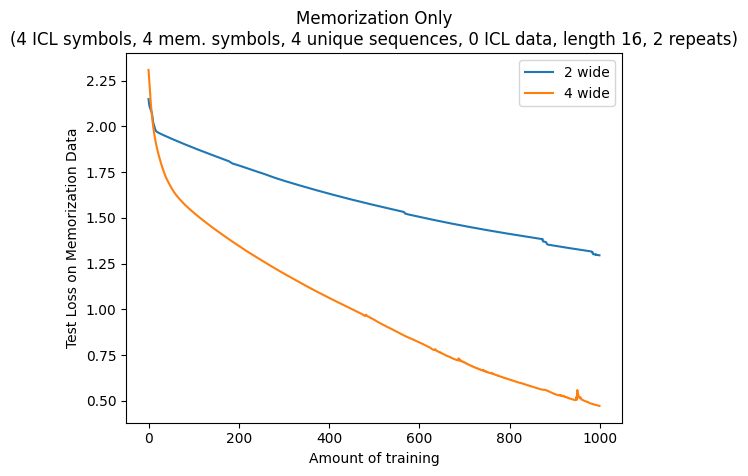

In [110]:
# 2 repeats
plot_from_archive(test_archive, widths, mem_symbols=mem_symbols, plot_title='Memorization Only', legend_str=' wide', icl=False, mean=True) #, 

In [17]:
icl_table, mem_table = get_threshold_passing_iterations(test_archive, widths, icl_threshold=1.5, mem_threshold=0.6, iter_or_bool='iter', hparam_str='param')

/var/folders/sf/b9wt34ws76j3hpw7q2tj82rh0000gn/T/ipykernel_63201/2102982727.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  icl_across_runs[idx] = torch.tensor(icl_test_accs)
/var/folders/sf/b9wt34ws76j3hpw7q2tj82rh0000gn/T/ipykernel_63201/2102982727.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mem_across_runs[idx] = torch.tensor(mem_test_accs)


In [18]:
mem_table

tensor([ nan, 821.])

### Parameter Count Experiments

#### vary width

##### memorization only

In [ ]:
# memorization only
seed = 0
icl_proportion = 0   ######
icl_symbols = 4
mem_symbols = 4
length = 16
iters = 1000
widths = [2,4,8,9,10] #128,256]
depth = 2
num_repeats = 10

torch.manual_seed(seed)
randomseed(seed)
np.random.seed(seed)

# generate unique sequence outside of loop, then input to trainer
dirichlet_markov_ensemble = torch.distributions.dirichlet.Dirichlet(torch.ones((mem_symbols,mem_symbols), device = device))
fixed = dirichlet_markov_ensemble.sample()
_, unique_sequences, _ = data_gen_fixed(length, fixed, num=1, uniques=4, offset=icl_symbols) # generate a single unique sequence for memorization task, already offset

# use unique sequences from mixed task, have this be entire dataset
mem_archive = []
for idx, width in enumerate(widths):
    model = gpt(icl_symbols+mem_symbols, icl_symbols+mem_symbols, drop=0,hid_dim=width, n_head=1, n_layer=depth, max_position=length-1)
    model.to(device)
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr= 3e-4, weight_decay= 0)
    loss_fn = nn.CrossEntropyLoss()
    run_results = trainer(model, iters, opt, loss_fn, length, icl_symbols, icl_proportion, every=1, device=device, fixed=fixed, batchsize=64, data_gen_batches=None, uniques=unique_sequences, sequence_sample_probs=None, num_repeats=num_repeats)
    mem_archive.append(run_results)

Progress: 100%|████████████████████████████████████████████████| 1001/1001 [00:08<00:00, 118.89it/s]


final loss= 1.289692


Progress: 100%|████████████████████████████████████████████████| 1001/1001 [00:08<00:00, 114.14it/s]


final loss= 0.284397


Progress: 100%|█████████████████████████████████████████████████| 1001/1001 [00:10<00:00, 98.41it/s]


final loss= 0.118917


Progress: 100%|████████████████████████████████████████████████| 1001/1001 [00:09<00:00, 100.76it/s]


final loss= 0.114799


Progress: 100%|█████████████████████████████████████████████████| 1001/1001 [00:10<00:00, 92.16it/s]


final loss= 0.088001


Progress: 100%|█████████████████████████████████████████████████| 1001/1001 [00:10<00:00, 98.17it/s]


final loss= 0.058521


Progress: 100%|█████████████████████████████████████████████████| 1001/1001 [00:12<00:00, 82.47it/s]


final loss= 0.045374


Progress: 100%|█████████████████████████████████████████████████| 1001/1001 [00:10<00:00, 96.12it/s]

final loss= 0.039507


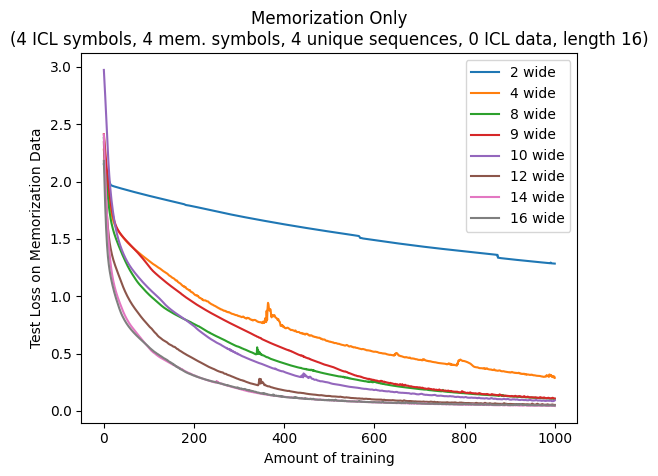

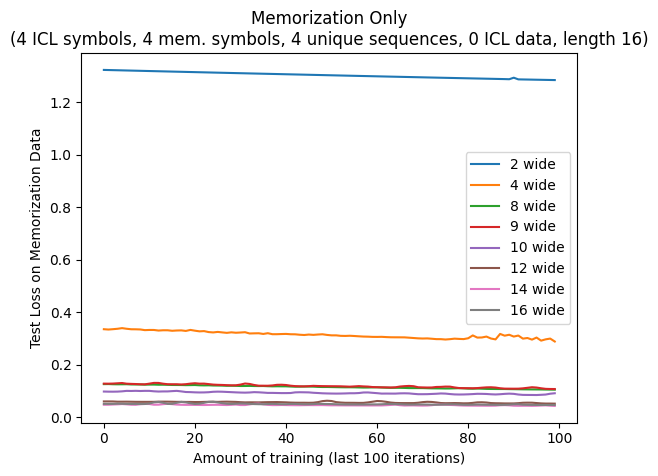

In [33]:
# memorization only
plot_from_archive(mem_archive, widths, mem_symbols=mem_symbols, plot_title='Memorization Only', legend_str=' wide', icl=False, mem_last=100) #, fixed_mc=True)

eg. it takes width 10 to achieve 0.1 memorization loss by 1000 iterations

##### icl only

In [ ]:
# icl only (same settings as in memorization)
seed = 0
icl_proportion = 1

torch.manual_seed(seed)
randomseed(seed)
np.random.seed(seed)

# use data from dirichlet online, have this be entire dataset
icl_archive = []
for idx, width in enumerate(widths):
    model = gpt(icl_symbols+mem_symbols, icl_symbols+mem_symbols, drop=0,hid_dim=width, n_head=1, n_layer=depth, max_position=length-1)
    model.to(device)
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr= 3e-4, weight_decay= 0)
    loss_fn = nn.CrossEntropyLoss()
    run_results = trainer(model, iters, opt, loss_fn, length, icl_symbols, icl_proportion, every=1, device=device, fixed=fixed, batchsize=64, data_gen_batches=None, uniques=unique_sequences, sequence_sample_probs=None, num_repeats=num_repeats)
    icl_archive.append(run_results)

Progress: 100%|████████████████████████████████████████████████| 1001/1001 [00:08<00:00, 118.05it/s]


final loss= 1.621491


Progress: 100%|████████████████████████████████████████████████| 1001/1001 [00:09<00:00, 109.11it/s]


final loss= 1.413613


Progress: 100%|████████████████████████████████████████████████| 1001/1001 [00:09<00:00, 106.53it/s]


final loss= 1.357084


Progress: 100%|█████████████████████████████████████████████████| 1001/1001 [00:11<00:00, 86.34it/s]


final loss= 1.347703


Progress: 100%|█████████████████████████████████████████████████| 1001/1001 [00:10<00:00, 95.05it/s]


final loss= 1.381064


Progress: 100%|█████████████████████████████████████████████████| 1001/1001 [00:10<00:00, 94.28it/s]


final loss= 1.357723


Progress: 100%|█████████████████████████████████████████████████| 1001/1001 [00:10<00:00, 93.63it/s]


final loss= 1.373269


Progress: 100%|████████████████████████████████████████████████| 1001/1001 [00:09<00:00, 100.48it/s]

final loss= 1.360381


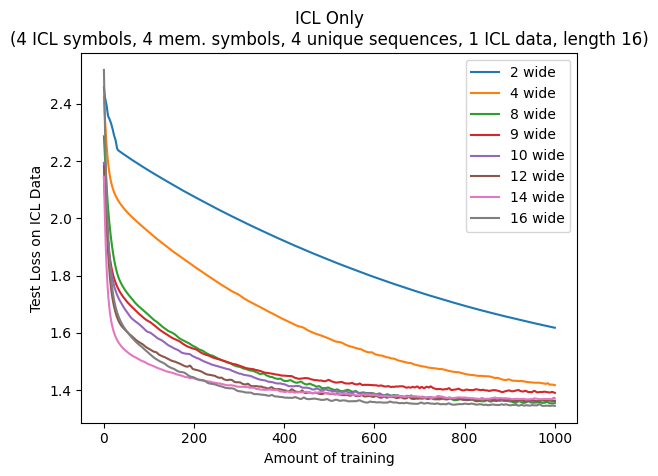

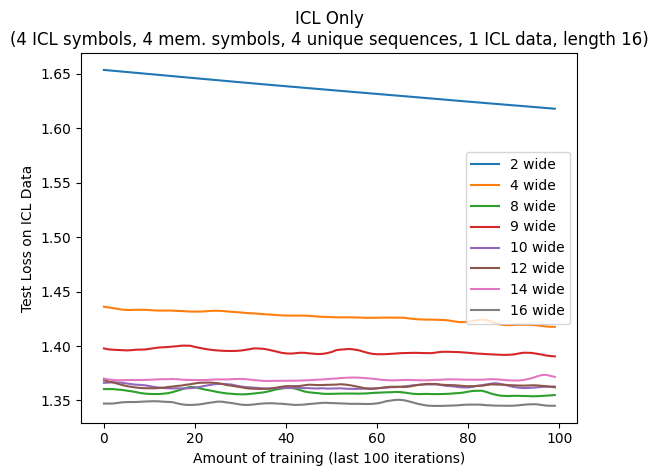

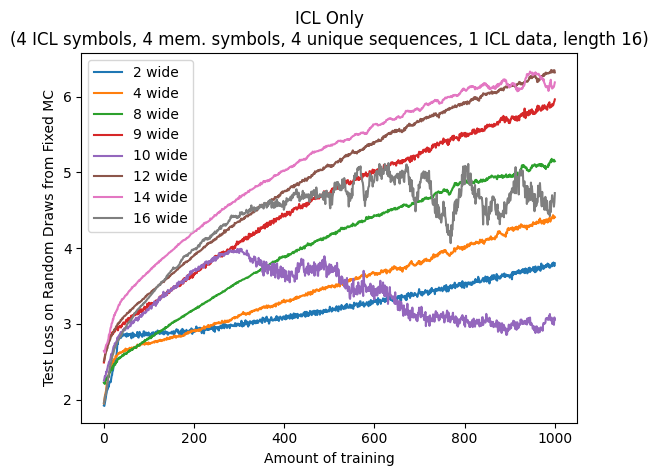

In [36]:
# icl only
plot_from_archive(icl_archive, widths, mem_symbols=mem_symbols, plot_title='ICL Only', legend_str=' wide', mem=False, icl_last=100, fixed_mc=True)

In [ ]:
# icl only (exploring best icl performance possible)
seed = 0
icl_proportion = 1
iters = 10000
widths = [8,]

torch.manual_seed(seed)
randomseed(seed)
np.random.seed(seed)

# use data from dirichlet online, have this be entire dataset
icl_archive2 = []
for idx, width in enumerate(widths):
    model = gpt(icl_symbols+mem_symbols, icl_symbols+mem_symbols, drop=0,hid_dim=width, n_head=1, n_layer=depth, max_position=length-1)
    model.to(device)
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr= 3e-4, weight_decay= 0)
    loss_fn = nn.CrossEntropyLoss()
    run_results = trainer(model, iters, opt, loss_fn, length, icl_symbols, icl_proportion, every=1, device=device, fixed=fixed, batchsize=64, data_gen_batches=None, uniques=unique_sequences, sequence_sample_probs=None, num_repeats=num_repeats)
    icl_archive2.append(run_results)

Progress: 100%|███████████████████████████████████████████████| 10001/10001 [02:00<00:00, 82.79it/s]

final loss= 1.322382


In [ ]:
# icl only
plot_from_archive(icl_archive2, widths, mem_symbols=mem_symbols, plot_title='ICL Only', legend_str=' wide', mem=False, icl_last=100, fixed_mc=True)

In [ ]:
icl_table2, _ = get_threshold_passing_iterations(icl_archive2, widths, icl_threshold=1.4, iter_or_bool='iter', hparam_str='width') 
# icl_threshold=1.5, mem_threshold=0.1, 
display(icl_table2)

##### mixed

In [ ]:
# mixed: 4 icl, 4 mem symbols, 4 unique sequences to memorize, length 16, 50% split
seed = 0
icl_proportion = 0.5 #####

torch.manual_seed(seed)
randomseed(seed)
np.random.seed(seed)

mixed_archive = []
for idx, width in enumerate(widths):
    model = gpt(icl_symbols+mem_symbols, icl_symbols+mem_symbols, drop=0,hid_dim=width, n_head=1, n_layer=depth, max_position=length-1)
    model.to(device)
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr= 3e-4, weight_decay= 0)
    loss_fn = nn.CrossEntropyLoss()
    run_results = trainer(model, iters, opt, loss_fn, length, icl_symbols, icl_proportion, every=1, device=device, fixed=fixed, batchsize=64, data_gen_batches=None, uniques=unique_sequences, sequence_sample_probs=None, num_repeats=num_repeats)
    mixed_archive.append(run_results)

Progress: 100%|████████████████████████████████████████████████| 1001/1001 [00:08<00:00, 117.00it/s]


final loss= 1.413146


Progress: 100%|████████████████████████████████████████████████| 1001/1001 [00:07<00:00, 134.45it/s]


final loss= 0.942045


Progress: 100%|████████████████████████████████████████████████| 1001/1001 [00:09<00:00, 108.87it/s]


final loss= 0.810242


Progress: 100%|████████████████████████████████████████████████| 1001/1001 [00:09<00:00, 101.80it/s]


final loss= 0.623076


Progress: 100%|█████████████████████████████████████████████████| 1001/1001 [00:10<00:00, 97.29it/s]


final loss= 0.626453


Progress: 100%|█████████████████████████████████████████████████| 1001/1001 [00:11<00:00, 89.81it/s]


final loss= 0.587469


Progress: 100%|█████████████████████████████████████████████████| 1001/1001 [00:10<00:00, 93.47it/s]


final loss= 0.709639


Progress: 100%|█████████████████████████████████████████████████| 1001/1001 [00:12<00:00, 82.03it/s]

final loss= 0.720358


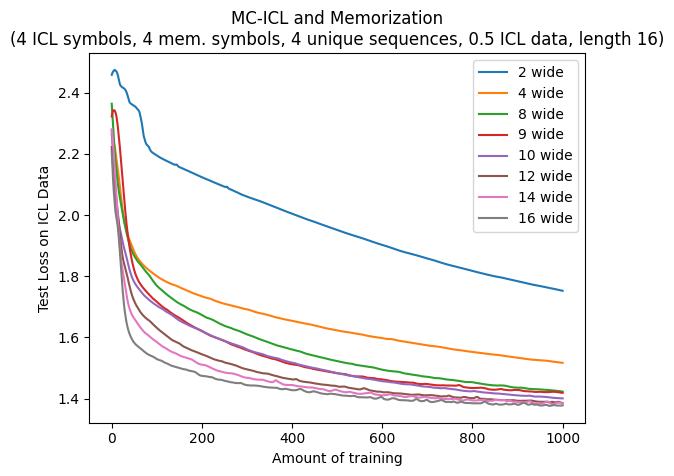

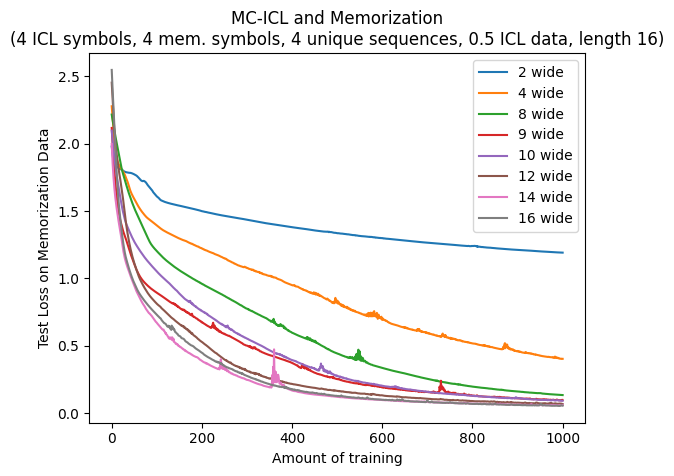

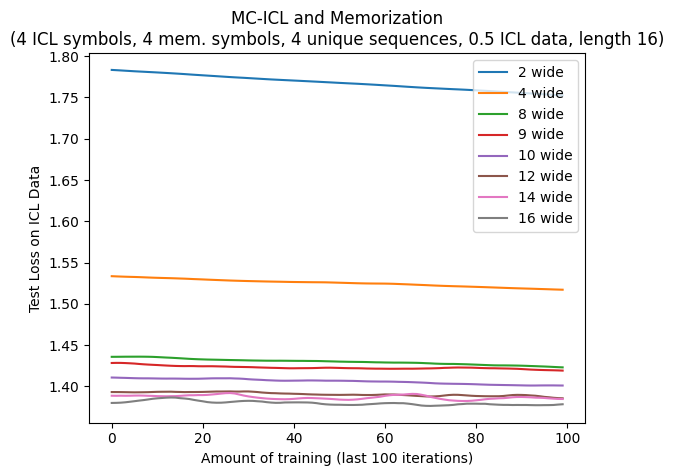

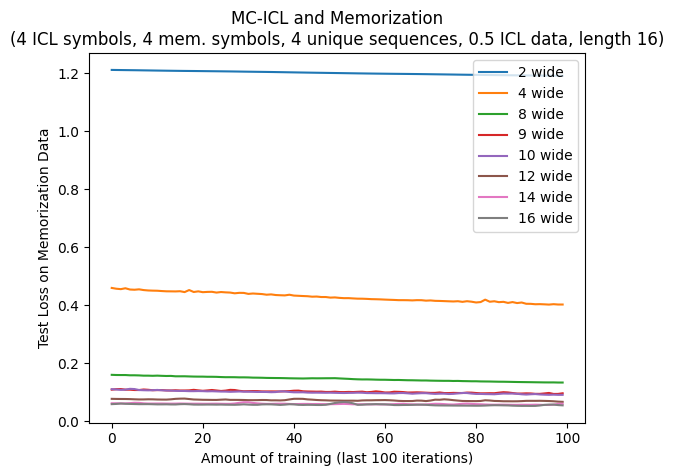

In [39]:
# ICL + memorization
plot_from_archive(mixed_archive, widths, mem_symbols=mem_symbols, legend_str=' wide', icl_last=100, mem_last=100)

In [40]:
icl_table, mem_table = get_threshold_passing_iterations(mixed_archive, widths, iter_or_bool='iter', hparam_str='width') 
# icl_threshold=1.5, mem_threshold=0.1, 
display(icl_table)
display(mem_table)

ICL
width       
2        NaN
4        NaN
8      586.0
9      441.0
10     449.0
12     290.0
14     222.0
16     150.0

Mem
width       
2        NaN
4        NaN
8        NaN
9      961.0
10     944.0
12     737.0
14     588.0
16     597.0

In [34]:
_, mem_table = get_threshold_passing_iterations(mem_archive, widths, iter_or_bool='iter', hparam_str='width') 
# icl_threshold=1.5, mem_threshold=0.1, 
display(mem_table)

Mem
width       
2        NaN
4        NaN
8        NaN
9        NaN
10     899.0
12     601.0
14     472.0
16     469.0

In [37]:
icl_table, _ = get_threshold_passing_iterations(icl_archive, widths, icl_threshold=1.4, iter_or_bool='iter', hparam_str='width') 
# icl_threshold=1.5, mem_threshold=0.1, 
display(icl_table)

ICL
width       
2        NaN
4        NaN
8      521.0
9      794.0
10     483.0
12     398.0
14     386.0
16     294.0

### Training Runs/Plotting

In [41]:
# varying depth, only 1 unique sequence to memorize, for now keep mem and ICL tokens separate
seed = 0
icl_symbols = 4
mem_symbols = 4
length = 32
iters = 2000
icl_proportion = 0.5
depths = [1,2,4]
# depths = [1, 2, 4, 8]

torch.manual_seed(seed)
randomseed(seed)
np.random.seed(seed)

# generate unique sequence outside of loop, then input to trainer - this means generating slightly different datasets each time... (check with ezra)
dirichlet_markov_ensemble = torch.distributions.dirichlet.Dirichlet(torch.ones((mem_symbols,mem_symbols), device = device))
fixed = dirichlet_markov_ensemble.sample()
_, unique_sequences, _ = data_gen_fixed(length, fixed, num=1, uniques=1, offset=icl_symbols) # generate a single unique sequence for memorization task, already offset

archive = []
for idx, depth in enumerate(depths):
    model = gpt(icl_symbols+mem_symbols, icl_symbols+mem_symbols, drop=0,hid_dim=16, n_head=1, n_layer=depth, max_position=length-1)
    model.to(device)
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr= 1e-3, weight_decay= 0)
    loss_fn = nn.CrossEntropyLoss()
    run_results = trainer(model, iters, opt, loss_fn, length, icl_symbols, icl_proportion, every=1, device=device, fixed=fixed, batchsize=64, data_gen_batches=None, uniques=unique_sequences, sequence_sample_probs=None)
    archive.append(run_results)

Progress: 100%|█████████████████████████████████████████████████| 2001/2001 [00:28<00:00, 69.21it/s]


final loss= 0.693943


Progress: 100%|█████████████████████████████████████████████████| 2001/2001 [00:43<00:00, 46.33it/s]


final loss= 0.656892


Progress: 100%|█████████████████████████████████████████████████| 2001/2001 [01:03<00:00, 31.61it/s]

final loss= 0.743249


In [76]:
# varying widths, only 1 unique sequence to memorize, for now keep mem and ICL tokens separate
seed = 0
icl_symbols = 4
mem_symbols = 4
length = 128
iters = 2000
icl_proportion = 0.5
depth = 2 
widths = [2,4,8,16,32]

torch.manual_seed(seed)
randomseed(seed)
np.random.seed(seed)

# generate unique sequence outside of loop, then input to trainer - this means generating slightly different datasets each time... (check with ezra)
dirichlet_markov_ensemble = torch.distributions.dirichlet.Dirichlet(torch.ones((mem_symbols,mem_symbols), device = device))
fixed = dirichlet_markov_ensemble.sample()
_, unique_sequences, _ = data_gen_fixed(length, fixed, num=1, uniques=1, offset=icl_symbols) # generate a single unique sequence for memorization task, already offset

archive = []
for idx, width in enumerate(widths):
    model = gpt(icl_symbols+mem_symbols, icl_symbols+mem_symbols, drop=0, hid_dim=width, n_head=1, n_layer=depth, max_position=length-1)
    model.to(device)
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr= 3e-4, weight_decay= 0)
    loss_fn = nn.CrossEntropyLoss()
    run_results = trainer(model, iters, opt, loss_fn, length, icl_symbols, icl_proportion, every=1, device=device, fixed=fixed, batchsize=64, data_gen_batches=None, uniques=unique_sequences, sequence_sample_probs=None)
    archive.append(run_results)

Progress: 100%|█████████████████████████████████████████████████| 2001/2001 [01:14<00:00, 26.86it/s]


final loss= 1.501624


Progress: 100%|█████████████████████████████████████████████████| 2001/2001 [01:13<00:00, 27.18it/s]


final loss= 0.782037


Progress: 100%|█████████████████████████████████████████████████| 2001/2001 [01:13<00:00, 27.24it/s]


final loss= 0.742249


Progress: 100%|█████████████████████████████████████████████████| 2001/2001 [01:42<00:00, 19.56it/s]


final loss= 0.733871


Progress: 100%|█████████████████████████████████████████████████| 2001/2001 [02:45<00:00, 12.12it/s]

final loss= 0.670678


In [55]:
# varying icl_proportion, only 1 unique sequence to memorize, for now keep mem and ICL tokens separate
seed = 0
icl_symbols = 4
mem_symbols = 4
length = 32
iters = 2000
depth = 2
icl_proportions = [0.5, 0.3, 0.1, 0.01, 0.001]
# icl_proportions = [0.5, 0.3, 0.1, 0.01, 0.001]

torch.manual_seed(seed)
randomseed(seed)
np.random.seed(seed)

# generate unique sequence outside of loop, then input to trainer - this means generating slightly different datasets each time...
dirichlet_markov_ensemble = torch.distributions.dirichlet.Dirichlet(torch.ones((mem_symbols,mem_symbols), device = device))
fixed = dirichlet_markov_ensemble.sample()
_, unique_sequences, _ = data_gen_fixed(length, fixed, num=1, uniques=1, offset=icl_symbols) # generate a single unique sequence for memorization task, already offset

archive = []
for idx, proportion in enumerate(icl_proportions):
    model = gpt(icl_symbols+mem_symbols, icl_symbols+mem_symbols, drop=0,hid_dim=16, n_head=1, n_layer=2, max_position=length-1)
    model.to(device)
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr= 1e-3, weight_decay= 0)
    loss_fn = nn.CrossEntropyLoss()
    run_results = trainer(model, iters, opt, loss_fn, length, icl_symbols, icl_proportion=proportion, every=1, device=device, fixed=fixed, batchsize=64, data_gen_batches=None, uniques=unique_sequences, sequence_sample_probs=None)
    archive.append(run_results)

Progress: 100%|████████████████████████████████████████████████| 2001/2001 [00:17<00:00, 117.01it/s]


final loss= 0.782456


Progress: 100%|████████████████████████████████████████████████| 2001/2001 [00:16<00:00, 120.19it/s]


final loss= 0.389930


Progress: 100%|████████████████████████████████████████████████| 2001/2001 [00:14<00:00, 141.59it/s]


final loss= 0.105917


Progress: 100%|████████████████████████████████████████████████| 2001/2001 [00:12<00:00, 154.00it/s]


final loss= 0.000536


Progress: 100%|████████████████████████████████████████████████| 2001/2001 [00:12<00:00, 154.47it/s]

final loss= 0.000634


In [63]:
# varying num unique sequences (keep uniform sampling), 50% memorization, keep mem and ICL tokens separate
seed = 0
icl_symbols = 4
mem_symbols = 4
length = 32
iters = 2000
depth = 2
icl_proportion = 0.5 ####
total_unique_sequences = 64
num_uniques = [2, 4, 8, 16, 32, 64]

torch.manual_seed(seed)
randomseed(seed)
np.random.seed(seed)

# generate unique sequence outside of loop, then input to trainer - this means generating slightly different datasets each time...
dirichlet_markov_ensemble = torch.distributions.dirichlet.Dirichlet(torch.ones((mem_symbols,mem_symbols), device = device))
fixed = dirichlet_markov_ensemble.sample()
_, unique_sequences, _ = data_gen_fixed(length, fixed, num=1, uniques=total_unique_sequences, offset=icl_symbols) # generate a single unique sequence for memorization task, already offset

archive = []
for idx, num_unique in enumerate(num_uniques):
    model = gpt(icl_symbols+mem_symbols, icl_symbols+mem_symbols, drop=0,hid_dim=16, n_head=1, n_layer=2, max_position=length-1)
    model.to(device)
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr= 1e-3, weight_decay= 0)
    loss_fn = nn.CrossEntropyLoss()
    run_results = trainer(model, iters, opt, loss_fn, length, icl_symbols, icl_proportion, every=1, device=device, fixed=fixed, batchsize=64, data_gen_batches=None, uniques=unique_sequences[:num_unique, :], sequence_sample_probs=None)
    archive.append(run_results)

Progress: 100%|█████████████████████████████████████████████████| 2001/2001 [00:31<00:00, 63.36it/s]


final loss= 0.756712


Progress: 100%|█████████████████████████████████████████████████| 2001/2001 [00:29<00:00, 66.88it/s]


final loss= 0.548290


Progress: 100%|█████████████████████████████████████████████████| 2001/2001 [00:32<00:00, 61.88it/s]


final loss= 0.782923


Progress: 100%|█████████████████████████████████████████████████| 2001/2001 [00:28<00:00, 69.42it/s]


final loss= 0.706890


Progress: 100%|█████████████████████████████████████████████████| 2001/2001 [00:26<00:00, 74.29it/s]


final loss= 0.734114


Progress: 100%|█████████████████████████████████████████████████| 2001/2001 [00:32<00:00, 61.09it/s]

final loss= 0.882500


### vary num unique sequences (4 icl, 4 mem, 2 layers, length 32)

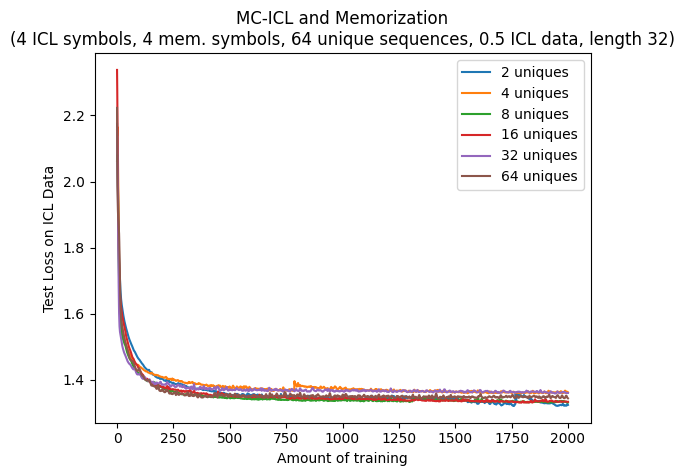

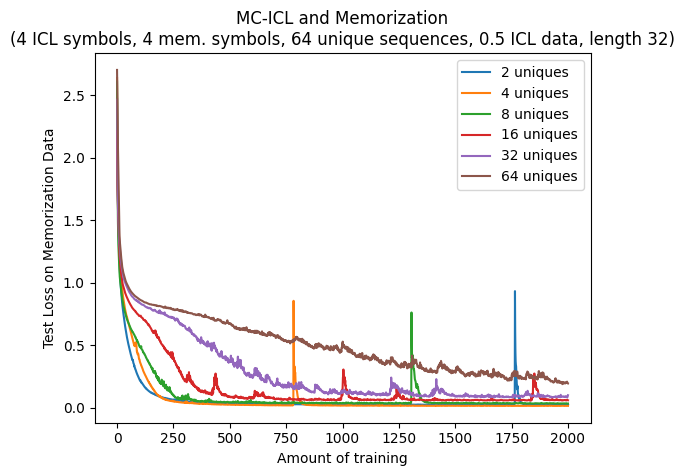

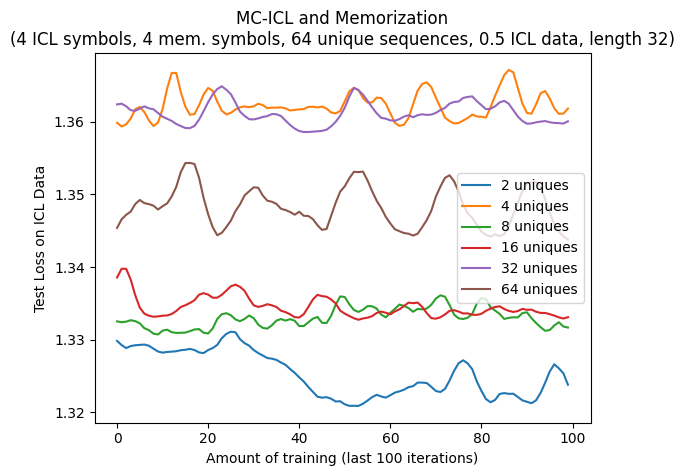

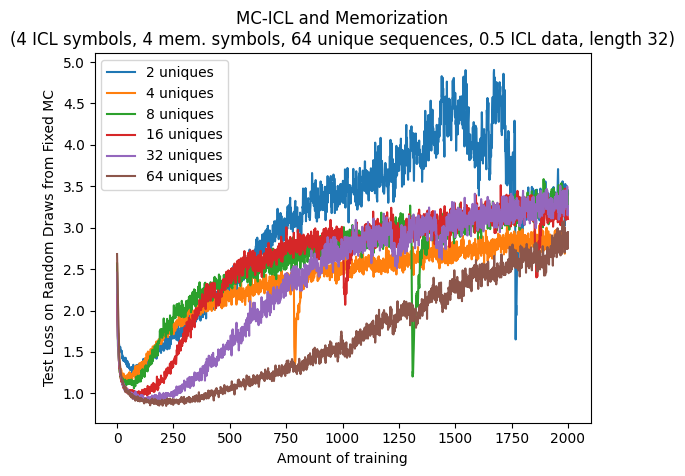

In [59]:
# seed 0
plot_from_archive(archive, num_uniques, mem_symbols=mem_symbols, legend_str=' uniques', fixed_mc=True, icl_last=100)

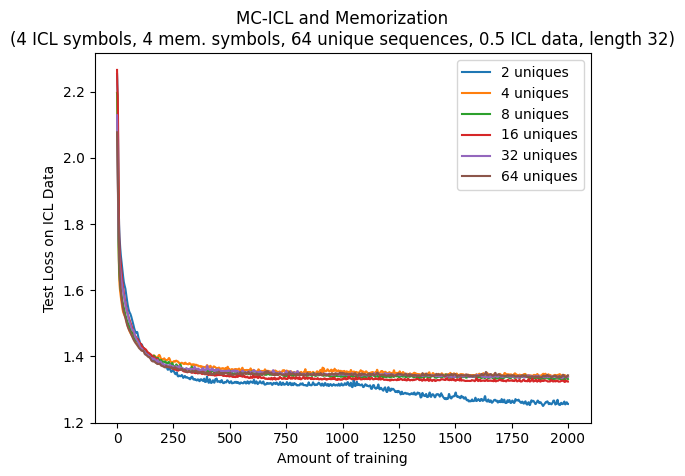

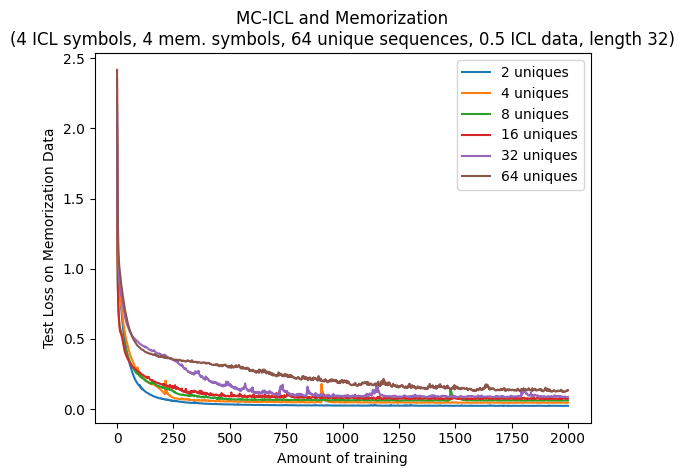

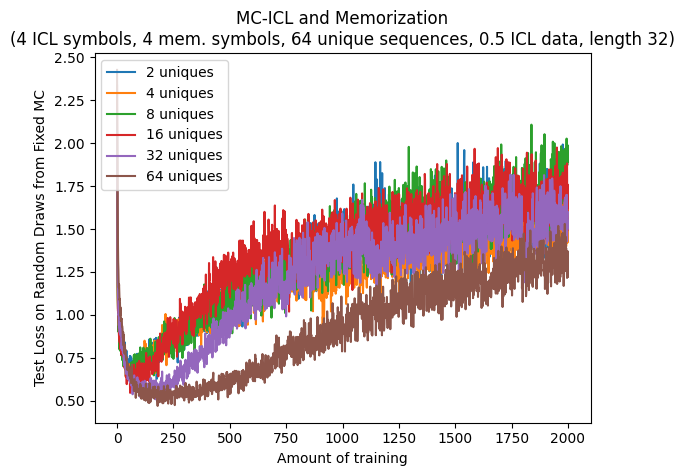

In [56]:
# seed 1
plot_from_archive(archive, num_uniques, mem_symbols=mem_symbols, legend_str=' uniques', fixed_mc=True)

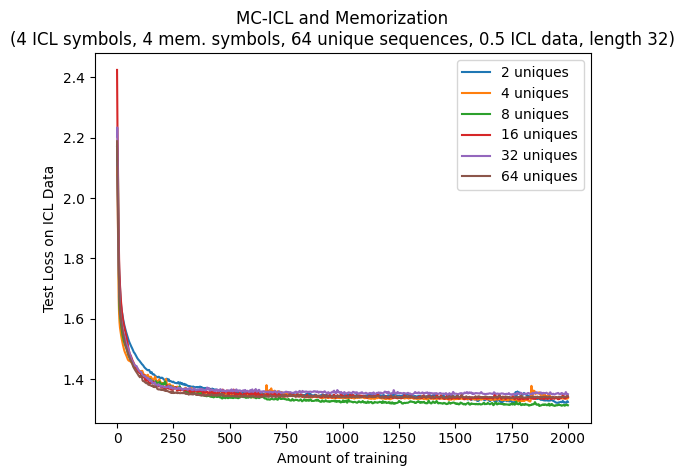

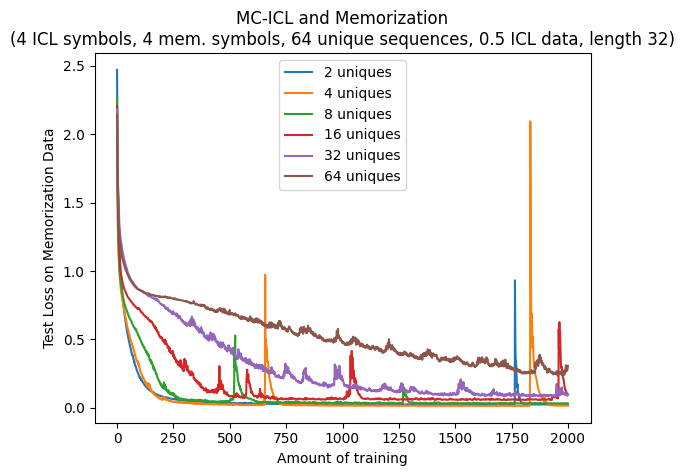

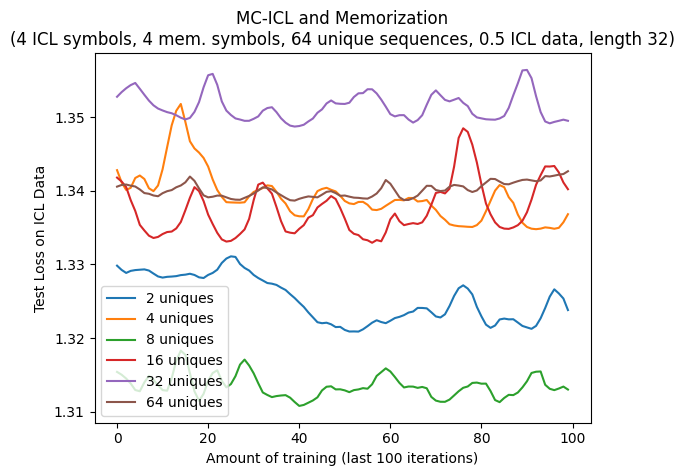

In [58]:
plot_from_archive(archive, num_uniques, mem_symbols=mem_symbols, legend_str=' uniques', fixed_mc=True)

In [ ]:
# also: test to see if we're just pushing up against learning the fixed MC itself...  write function to test this out

### vary icl proportion (4 icl, 4mem, 1 unique sequence, 2 layers, length 32)

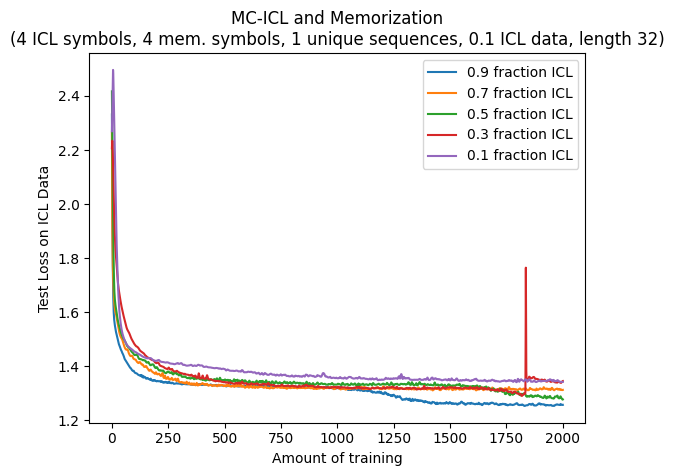

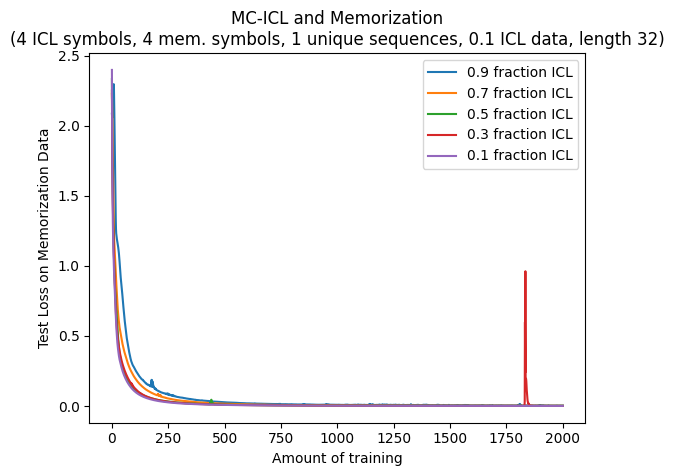

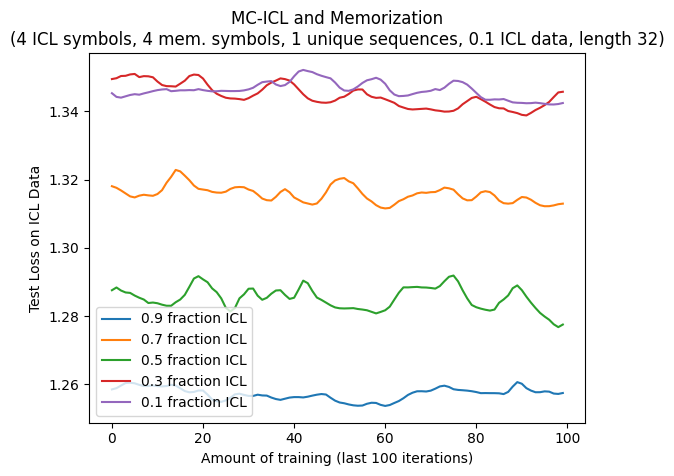

In [54]:
# 0.9, 0.7, 0.5, 0.3, 0.1
plot_from_archive(archive, icl_proportions, mem_symbols=mem_symbols, legend_str=' fraction ICL')

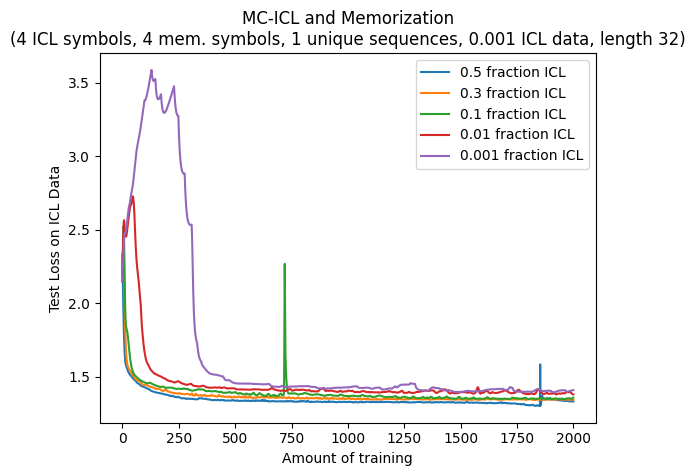

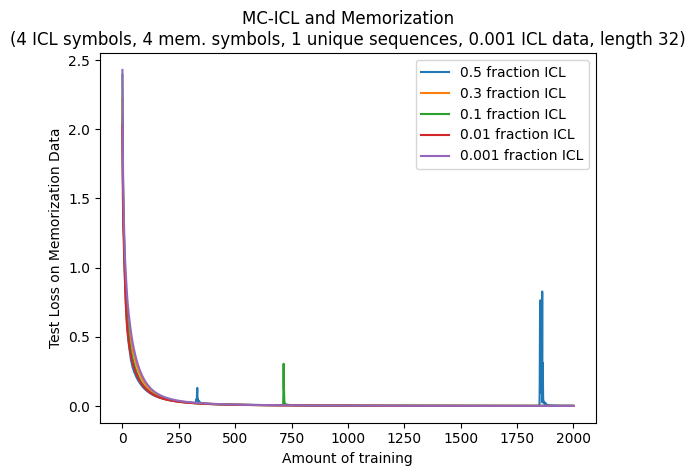

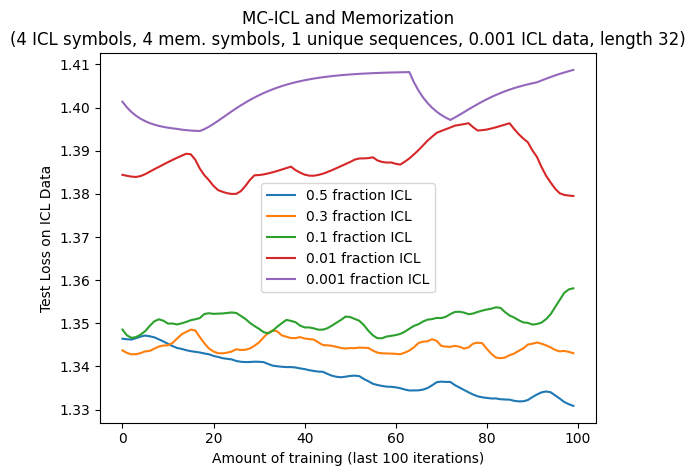

In [56]:
# 0.5, 0.3, 0.1, 0.01, 0.001
plot_from_archive(archive, icl_proportions, mem_symbols=mem_symbols, legend_str=' fraction ICL')

### vary length (and width) (4 icl, 4 mem, 1 unique sequence, 2 layers, 50% split), using lr 3e-4
varying length has very little change to memorization. at all lengths, basically perfect memorization loss, with very barely any improvement in icl loss as length increases. looks like something happens at length 128..

#### length 4

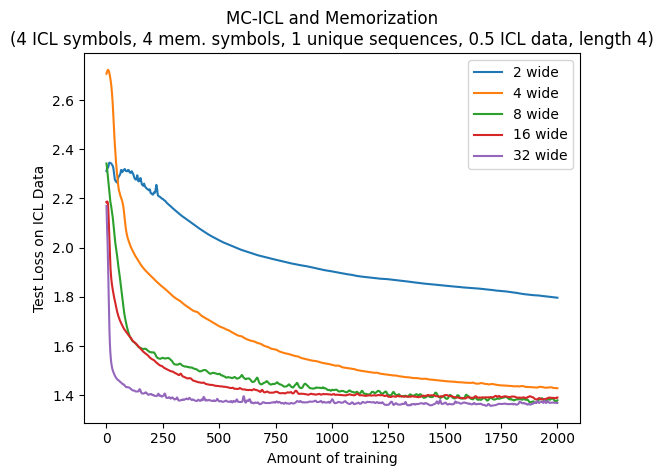

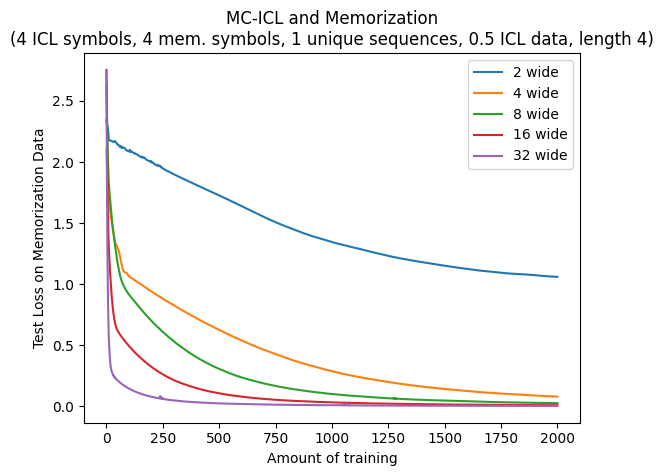

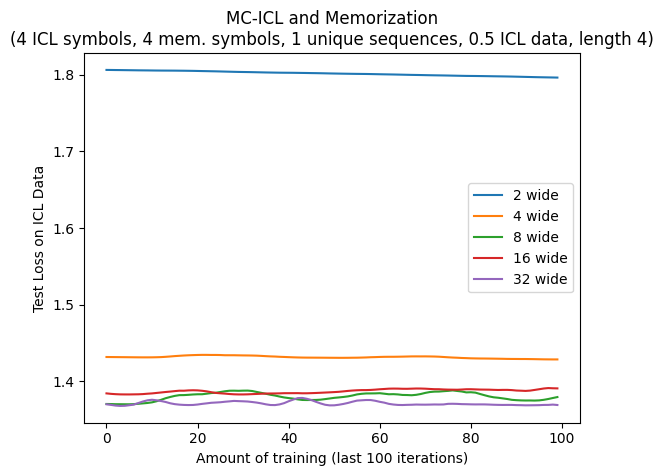

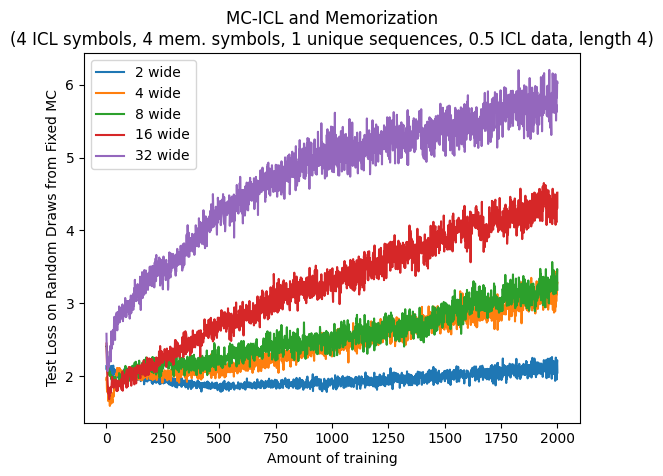

In [75]:
plot_from_archive(archive, widths, mem_symbols=mem_symbols, legend_str=' wide', icl_last=100, fixed_mc=True)

#### length 8

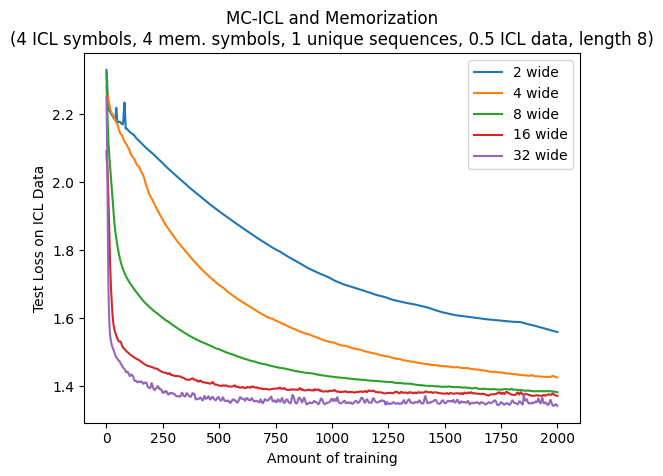

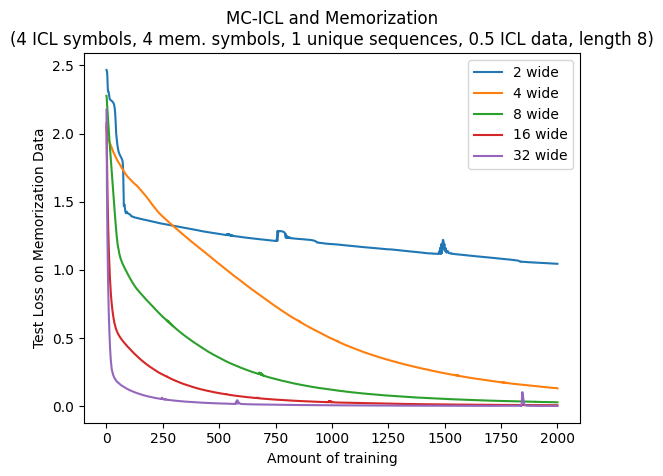

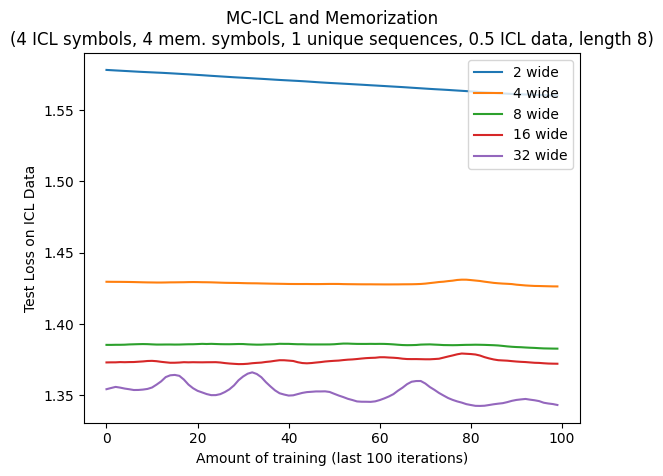

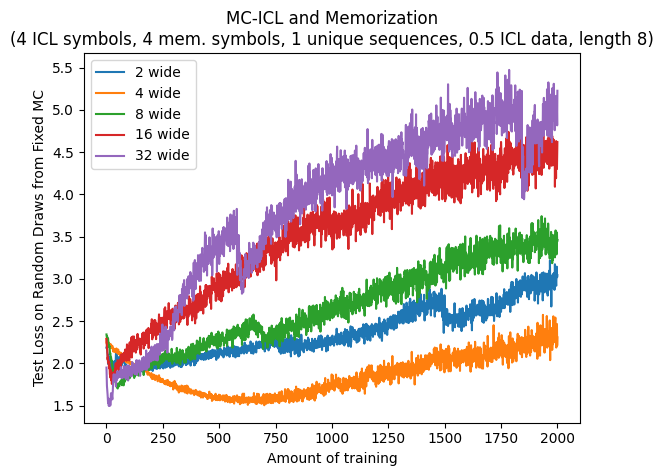

In [73]:
plot_from_archive(archive, widths, mem_symbols=mem_symbols, legend_str=' wide', icl_last=100, fixed_mc=True)

#### length 16

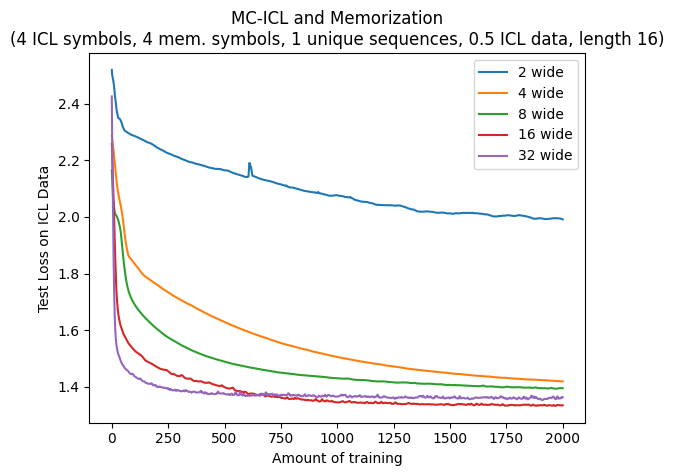

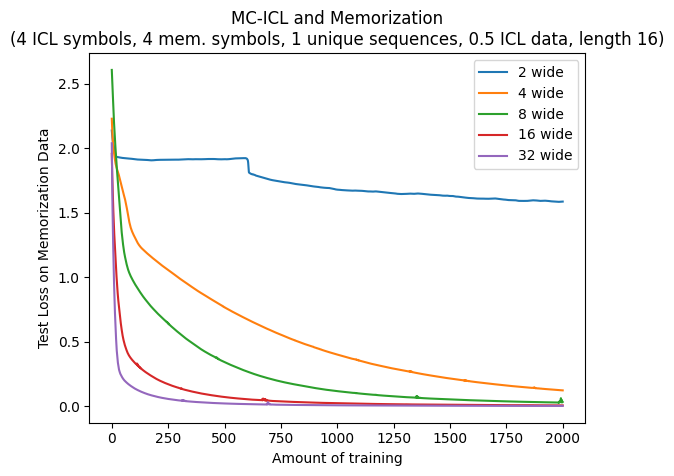

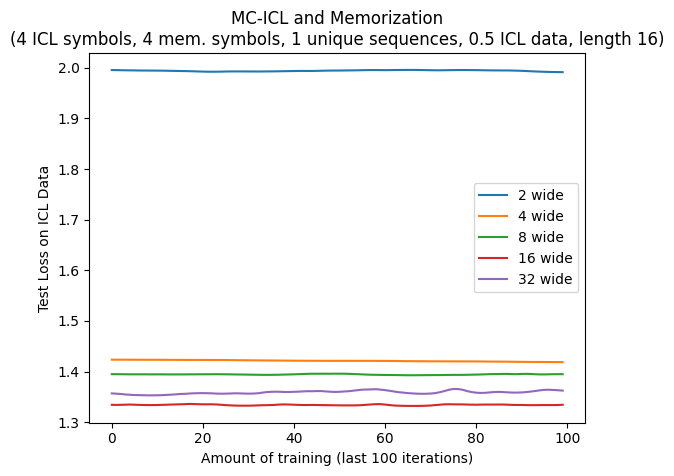

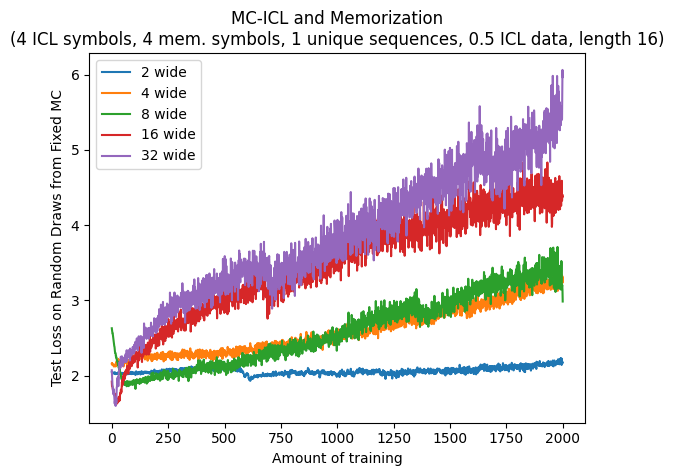

In [71]:
plot_from_archive(archive, widths, mem_symbols=mem_symbols, legend_str=' wide', icl_last=100, fixed_mc=True)

#### length 32

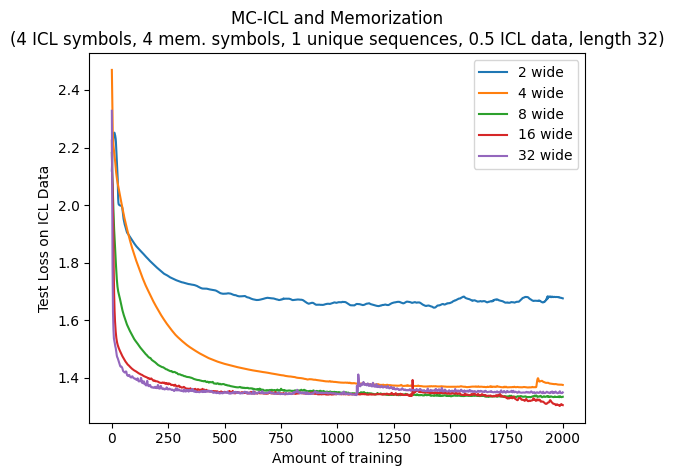

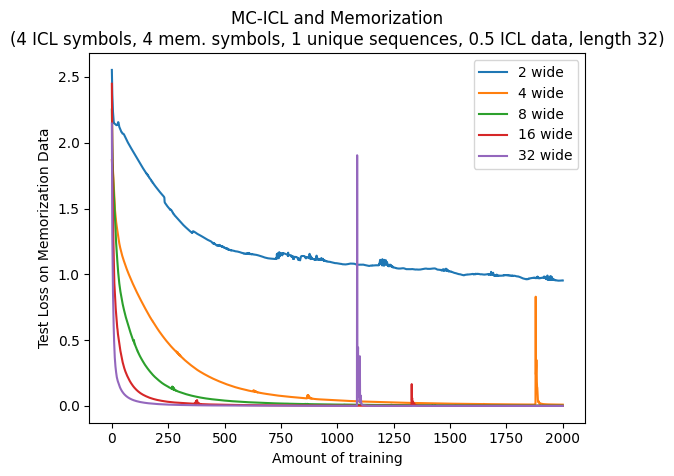

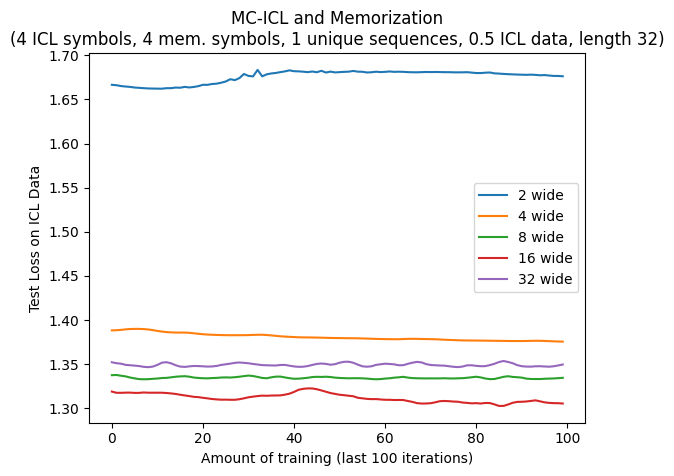

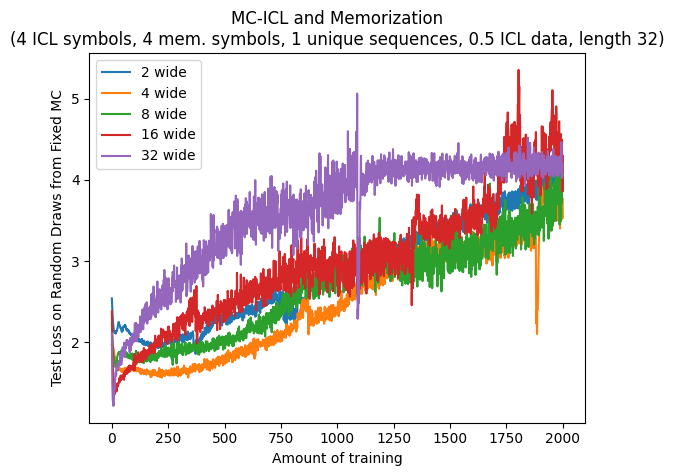

In [62]:
plot_from_archive(archive, widths, mem_symbols=mem_symbols, legend_str=' wide', icl_last=100, fixed_mc=True)

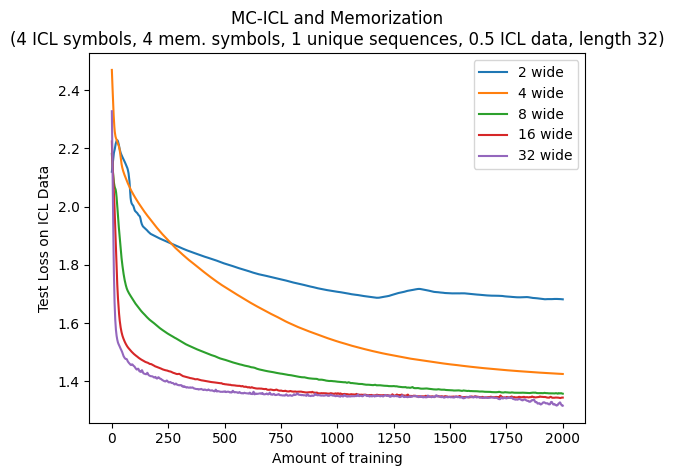

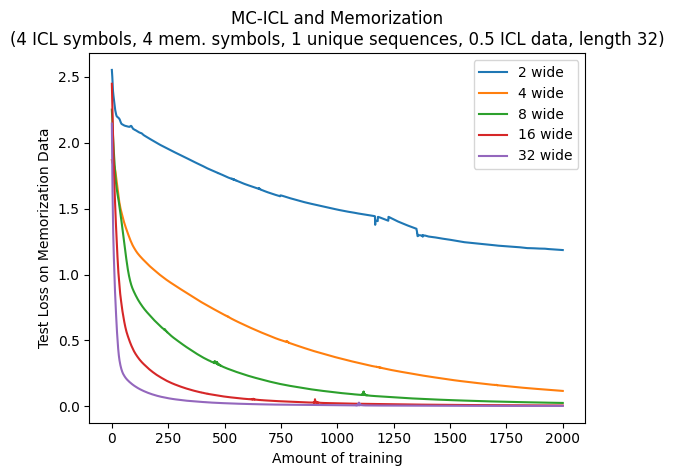

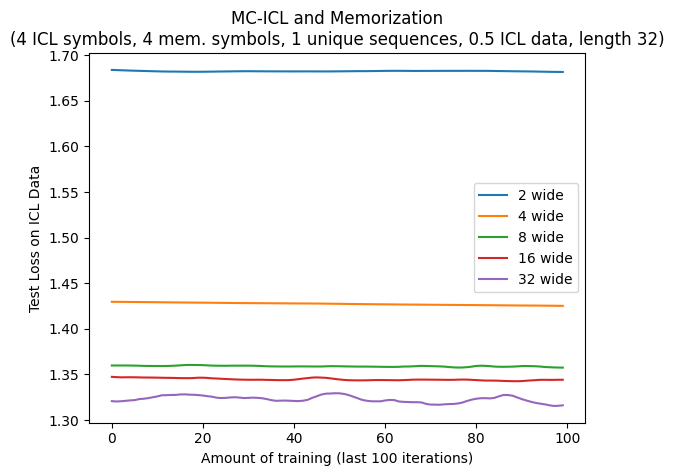

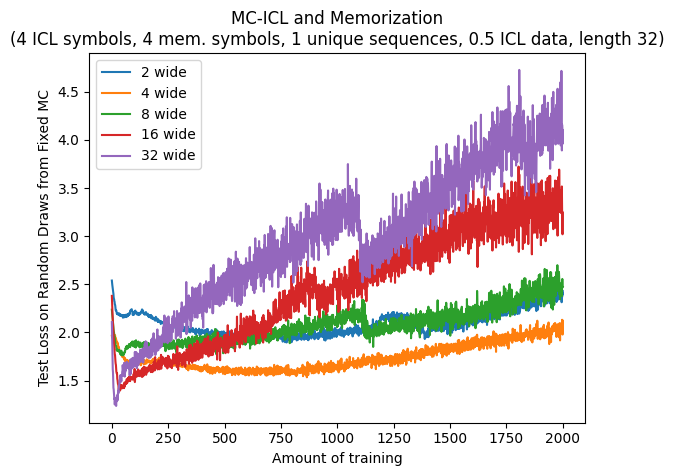

In [66]:
# reduce lr 1e-3 -> 3e-4
plot_from_archive(archive, widths, mem_symbols=mem_symbols, legend_str=' wide', icl_last=100, fixed_mc=True)

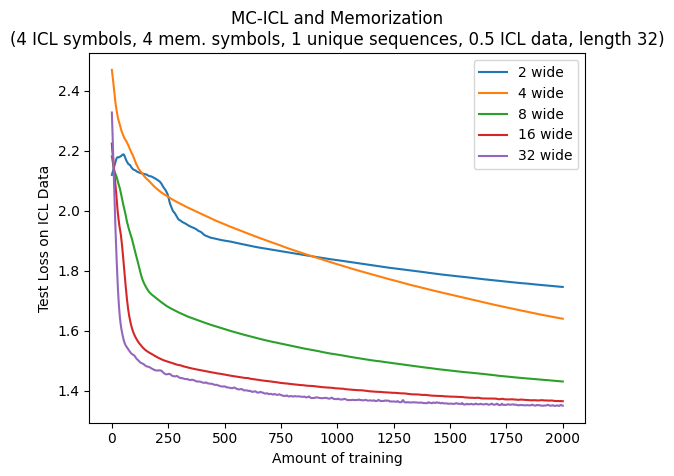

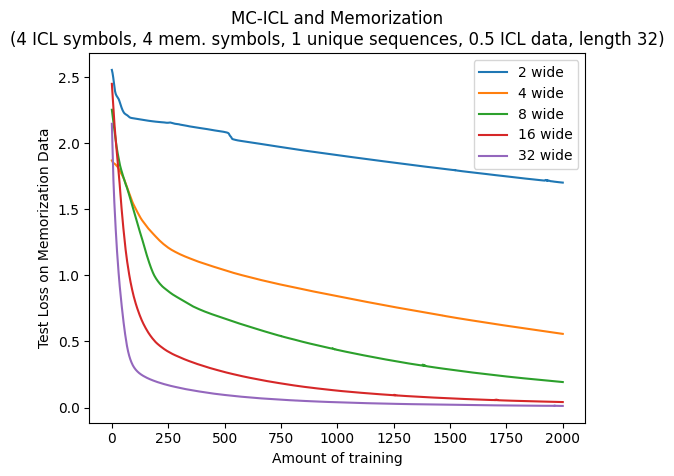

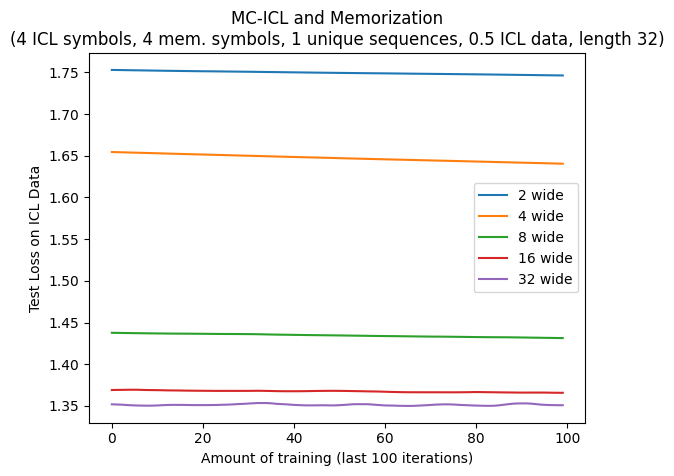

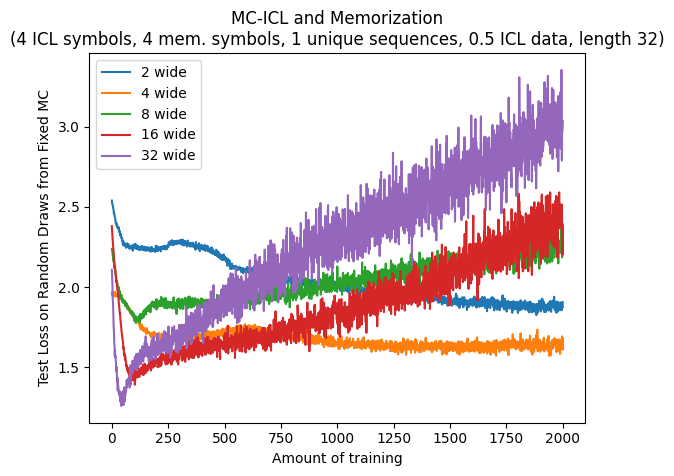

In [68]:
# reduce lr 1e-3 -> 1e-4
plot_from_archive(archive, widths, mem_symbols=mem_symbols, legend_str=' wide', icl_last=100, fixed_mc=True)

#### length 128

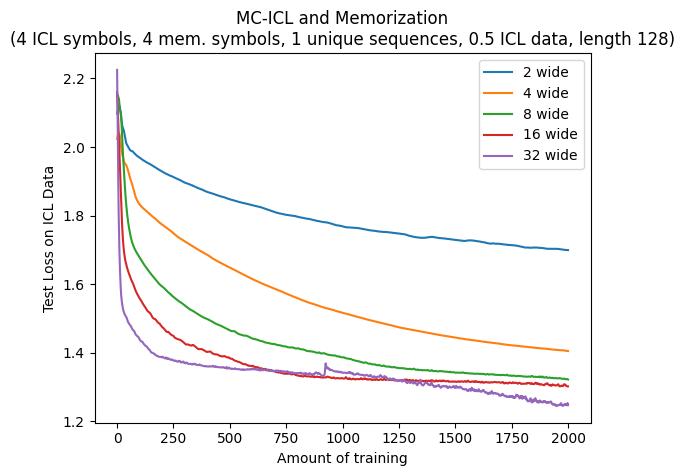

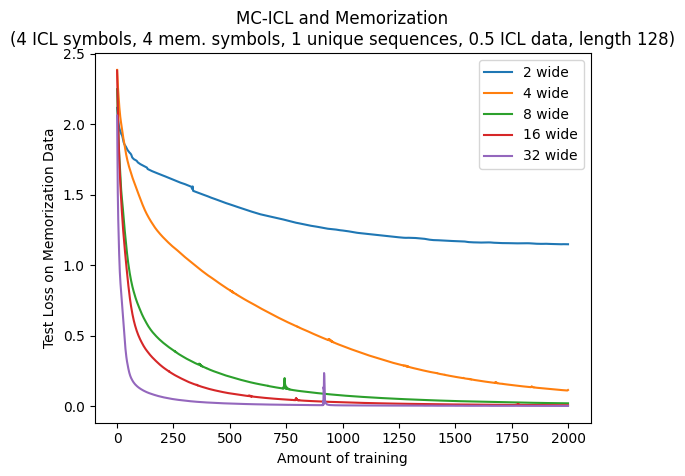

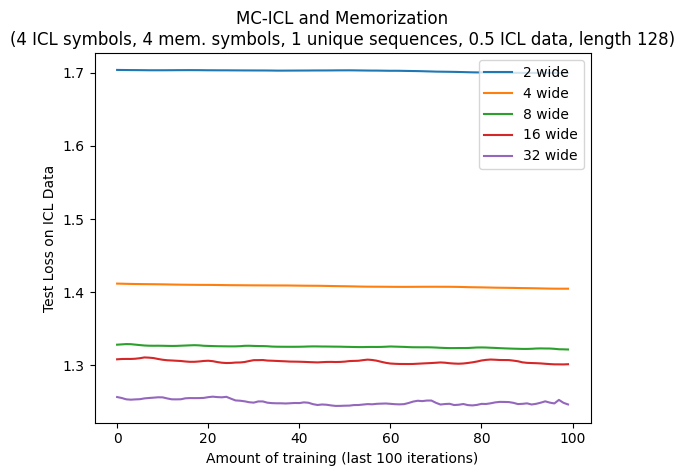

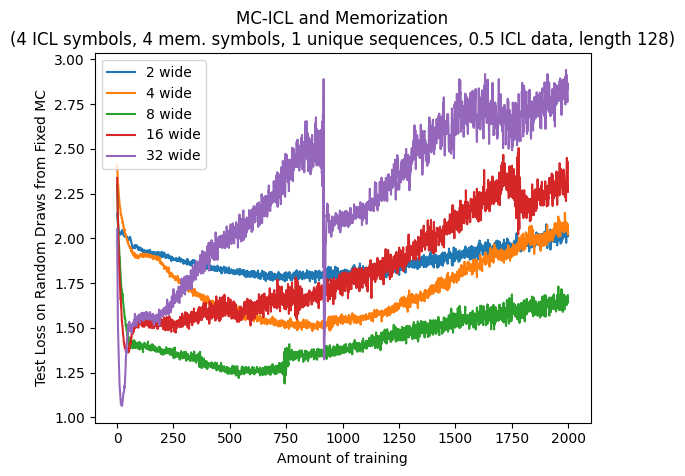

In [77]:
plot_from_archive(archive, widths, mem_symbols=mem_symbols, legend_str=' wide', icl_last=100, fixed_mc=True)

### vary depth (4 icl, 4 mem, 50% split, length 32)

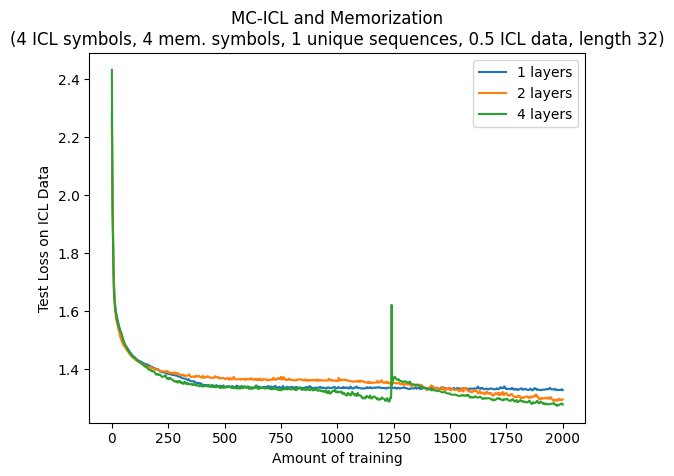

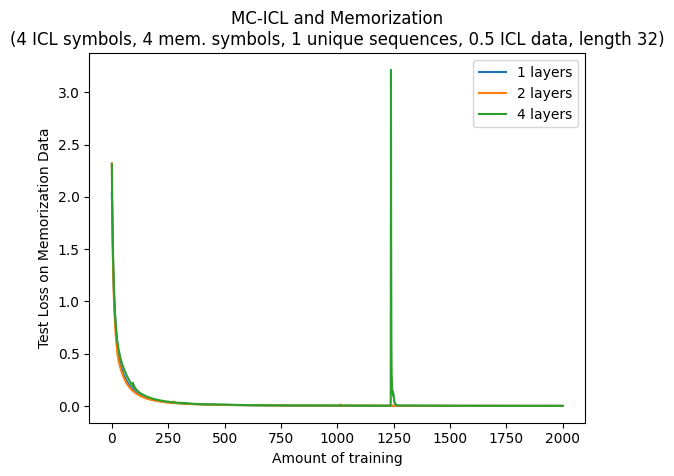

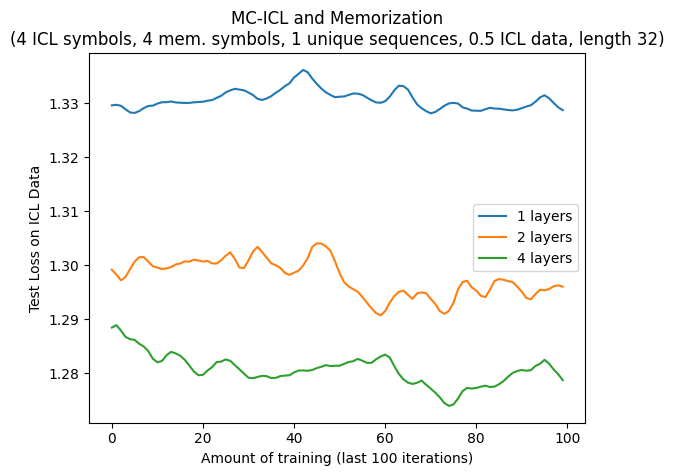

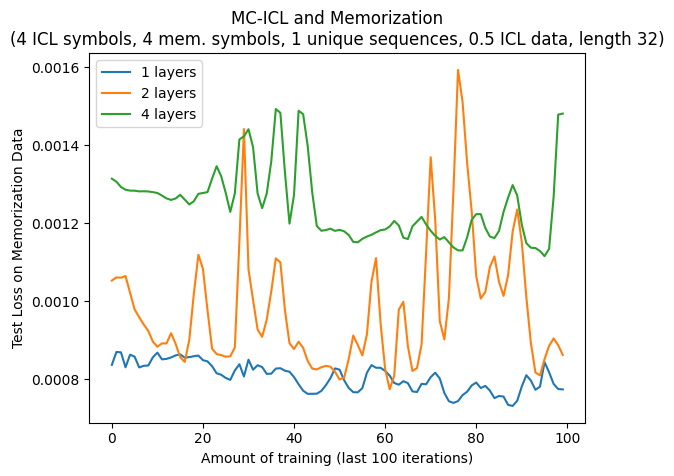

In [42]:
# seed 0
plot_from_archive(archive, depths, mem_symbols=mem_symbols, legend_str=' layers', icl_last=100, mem_last=100) 

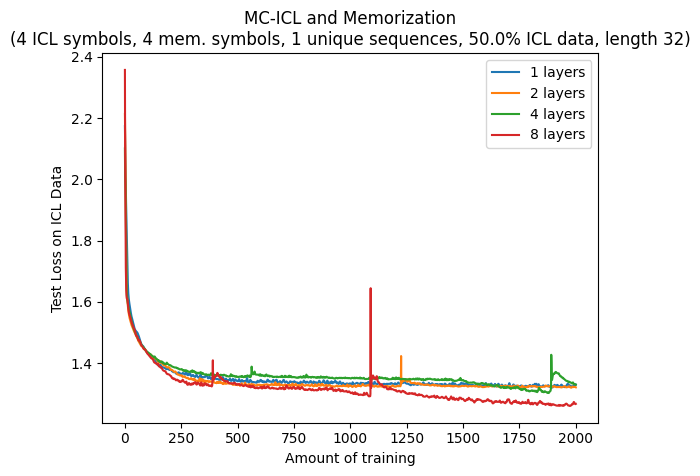

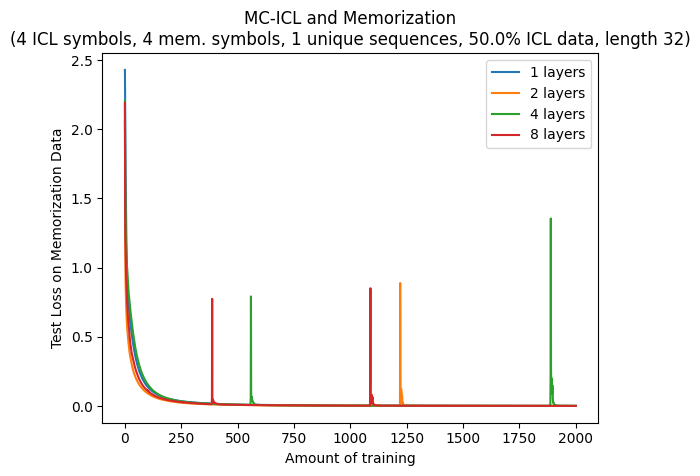

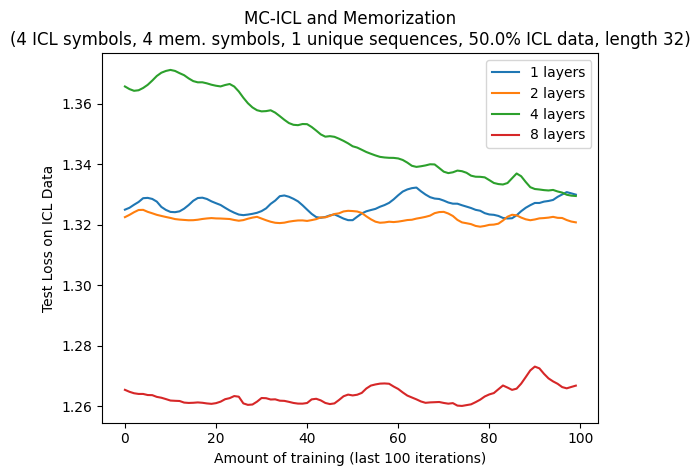

In [45]:
# seed 1
plot_from_archive(archive, depths, mem_symbols=mem_symbols, legend_str=' layers') 

#### 4 Mem, Length 10, vary ICL symbols (...)

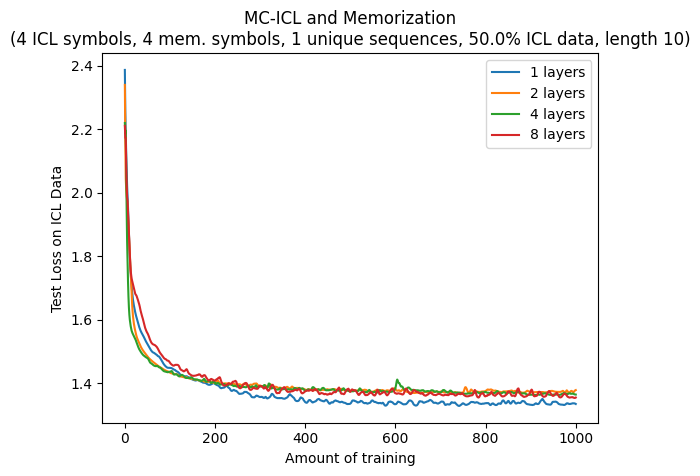

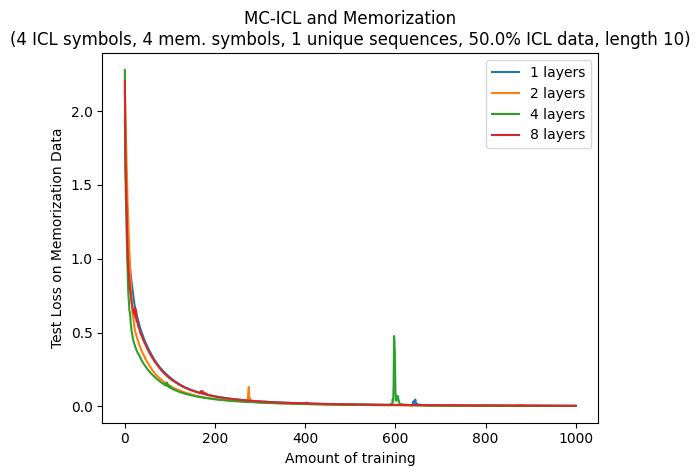

In [96]:
plot_from_archive(archive, depths, mem_symbols=mem_symbols, legend_str=' layers') # 4 icl symbols, 4 mem, length 10

#### 4 Mem, Length 30, vary ICL symbols (2, 4, 6)

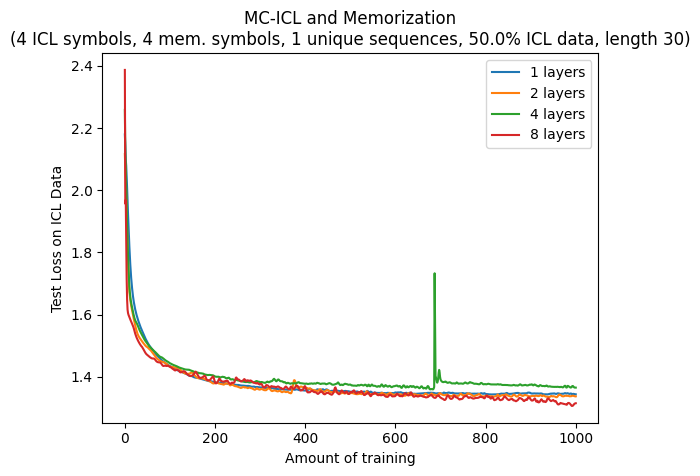

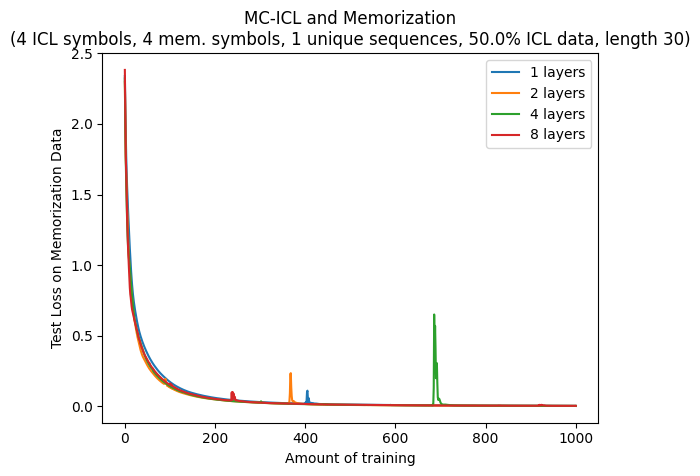

In [98]:
plot_from_archive(archive, depths, mem_symbols=mem_symbols, legend_str=' layers') # 6 icl symbols, 4 mem, length30 (1000 steps)

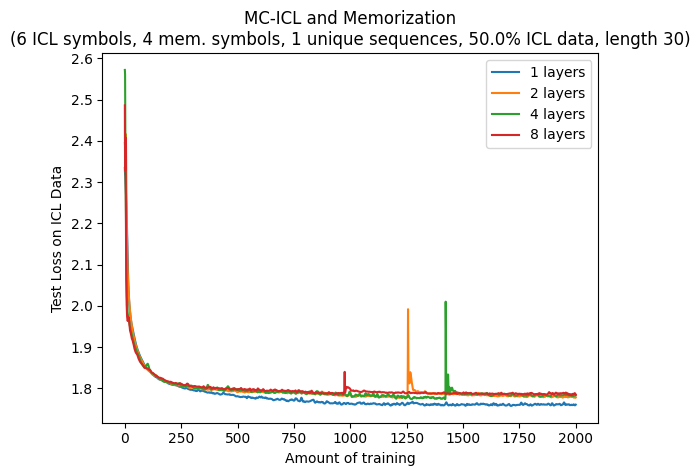

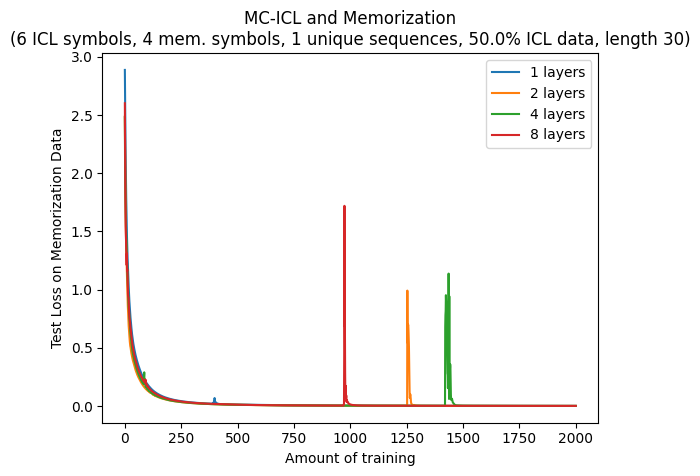

In [90]:
plot_from_archive(archive, depths, mem_symbols=mem_symbols, legend_str=' layers') # 6 icl symbols, 4 mem, length30

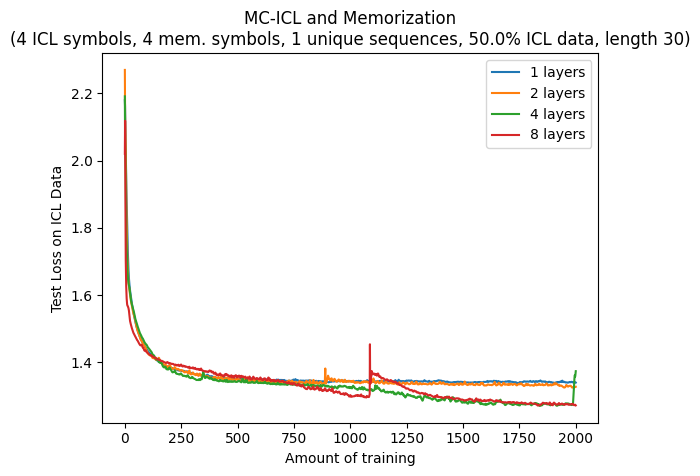

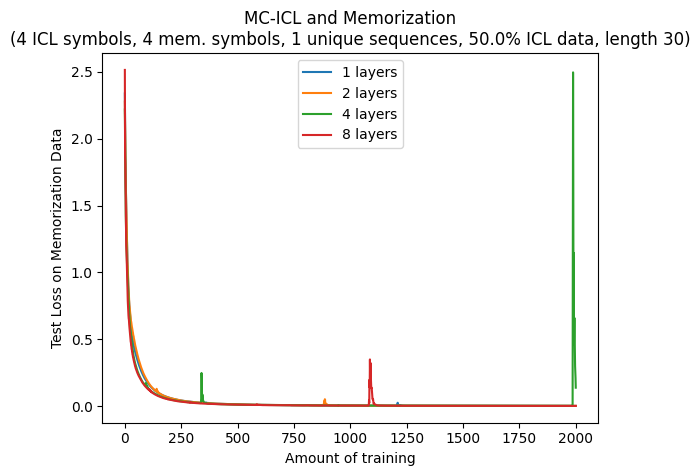

In [86]:
plot_from_archive(archive, depths, mem_symbols=mem_symbols, legend_str=' layers')

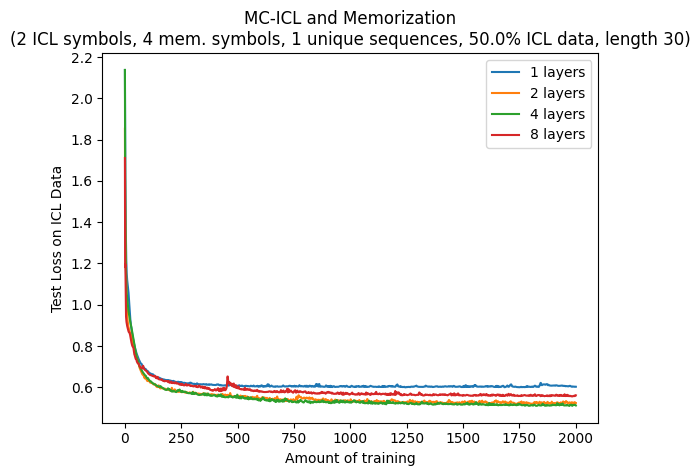

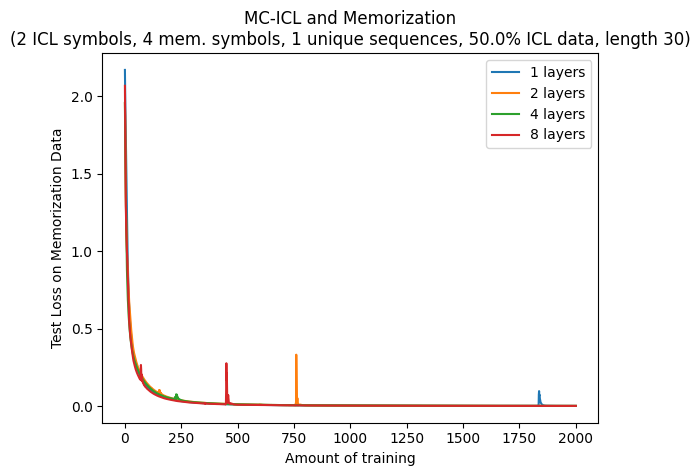

In [92]:
plot_from_archive(archive, depths, mem_symbols=mem_symbols, legend_str=' layers') # 2 icl symbols

#### 4 Mem, 4 ICL, length 64

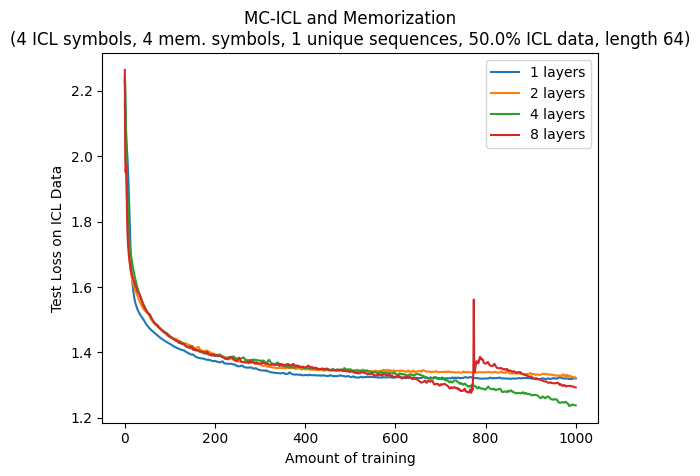

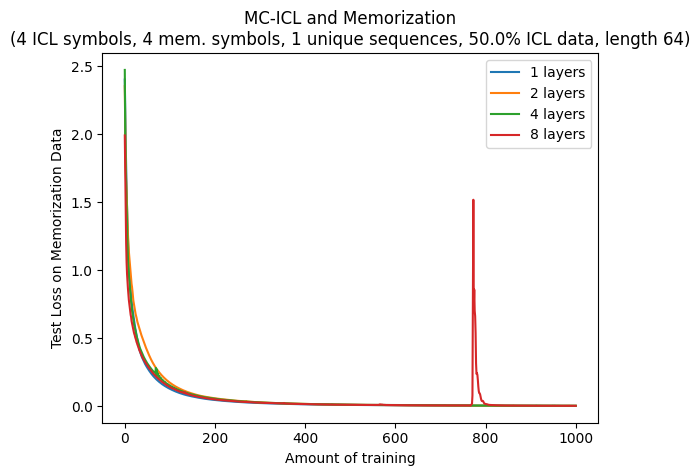

In [100]:
plot_from_archive(archive, depths, mem_symbols=mem_symbols, legend_str=' layers') # 1000 iters

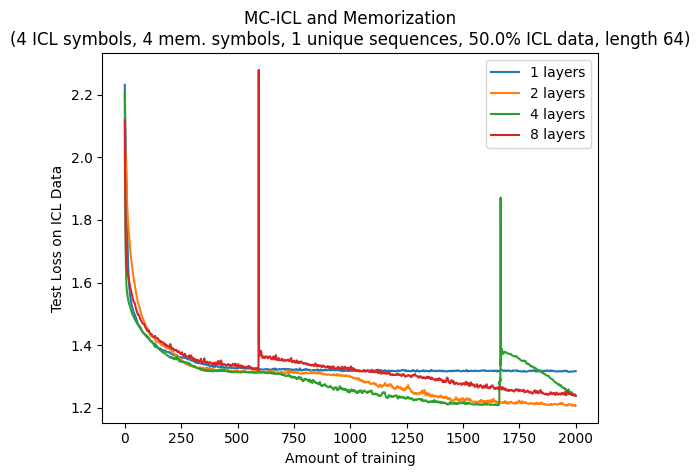

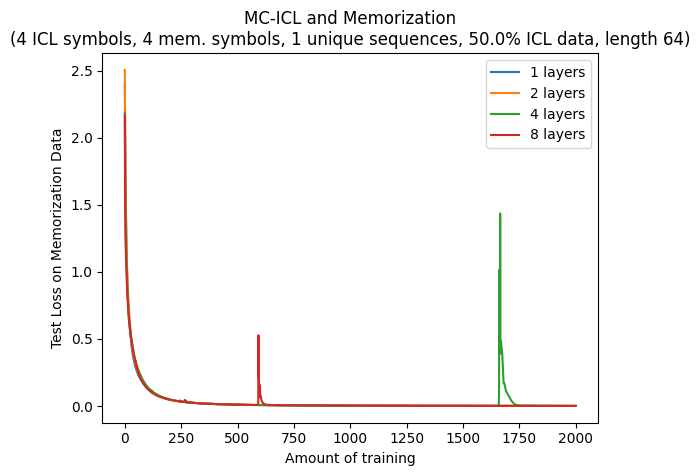

In [102]:
plot_from_archive(archive, depths, mem_symbols=mem_symbols, legend_str=' layers') # 2000 iters

#### 4 Mem 4 ICL, length 128

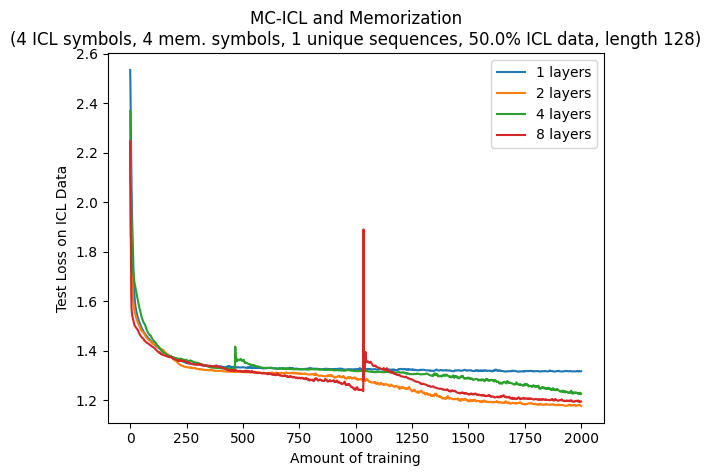

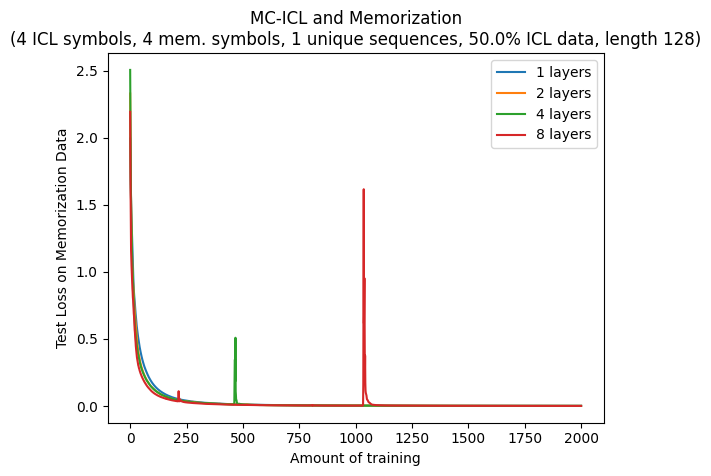

In [105]:
plot_from_archive(archive, depths, mem_symbols=mem_symbols, legend_str=' layers') # 2000 iters

#### Varying number of fixed/ICL symbols individually ('fixed' setting is learning fixed MC probabilities from context)

In [36]:
fixed_symbol_counts = [128, 64, 16, 4]
icl_symbol_counts = [128, 64, 16, 4]

In [37]:
# Training for varying num fixed symbols
key = 'fixed_symbol_counts'
seed = 0
length = 30
num_icl_symbols = 4
max_fixed_symbols = max(fixed_symbol_counts)
archive = []
for num_fixed_symbols in fixed_symbol_counts:
    torch.manual_seed(seed)
    randomseed(seed)
    np.random.seed(seed)
    fixed = torch.distributions.dirichlet.Dirichlet(torch.ones((num_fixed_symbols,num_fixed_symbols), device = device)).sample()
    model = gpt(num_icl_symbols+max_fixed_symbols,
                num_icl_symbols+max_fixed_symbols,
                drop = 0, hid_dim = 16, n_head = 1, n_layer = 2, max_position = length - 1)
    model.to(device= device)
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr= 1e-3, weight_decay= 0)
    loss_fn = nn.CrossEntropyLoss()
    # print(fixed)
    temp = trainer(model, 4000, opt, loss_fn, length, num_symbols=num_icl_symbols, every = 1, device= device, fixed = fixed)
    archive.append(temp)

Progress: 100%|█████████████████████████████████████████████████| 4001/4001 [00:48<00:00, 81.69it/s]


final loss= 2.875968


Progress: 100%|█████████████████████████████████████████████████| 4001/4001 [00:49<00:00, 80.69it/s]


final loss= 2.578505


Progress: 100%|█████████████████████████████████████████████████| 4001/4001 [00:52<00:00, 75.57it/s]


final loss= 1.848627


Progress: 100%|█████████████████████████████████████████████████| 4001/4001 [00:50<00:00, 78.70it/s]

final loss= 1.037867


In [41]:
# Training for varying num ICL symbols
key = 'icl_symbol_counts'
seed = 0
length = 30
num_fixed_symbols = 4
max_icl_symbols = max(icl_symbol_counts)
# max_icl_symbols = 8
archive = []
# for num_fixed_symbols in fixed_symbol_counts:
for num_icl_symbols in icl_symbol_counts:
    torch.manual_seed(seed)
    randomseed(seed)
    np.random.seed(seed)
    # fixed = torch.zeros((fixed_symbols+num_symbols, fixed_symbols+num_symbols), device = device)
    # fixed[:num_symbols,-fixed_symbols:] = 1/fixed_symbols
    # fixed[num_symbols:, num_symbols:] = torch.distributions.dirichlet.Dirichlet(torch.ones((fixed_symbols,fixed_symbols), device = device)).sample()
    fixed = torch.distributions.dirichlet.Dirichlet(torch.ones((num_fixed_symbols,num_fixed_symbols), device = device)).sample()
    model = gpt(num_fixed_symbols+max_icl_symbols,
                num_fixed_symbols+max_icl_symbols,
                drop = 0, hid_dim = 16, n_head = 1, n_layer = 2, max_position = length - 1)
    model.to(device= device)
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr= 1e-3, weight_decay= 0)
    loss_fn = nn.CrossEntropyLoss()
    # print(fixed)
    temp = trainer(model, 4000, opt, loss_fn, length, num_symbols=num_icl_symbols, every = 1, device= device, fixed = fixed)
    archive.append(temp)

Progress: 100%|█████████████████████████████████████████████████| 4001/4001 [00:59<00:00, 67.56it/s]


final loss= 2.841430


Progress: 100%|█████████████████████████████████████████████████| 4001/4001 [00:49<00:00, 80.27it/s]


final loss= 2.562690


Progress: 100%|█████████████████████████████████████████████████| 4001/4001 [00:50<00:00, 78.70it/s]


final loss= 1.791517


Progress: 100%|█████████████████████████████████████████████████| 4001/4001 [00:53<00:00, 74.93it/s]

final loss= 1.037867


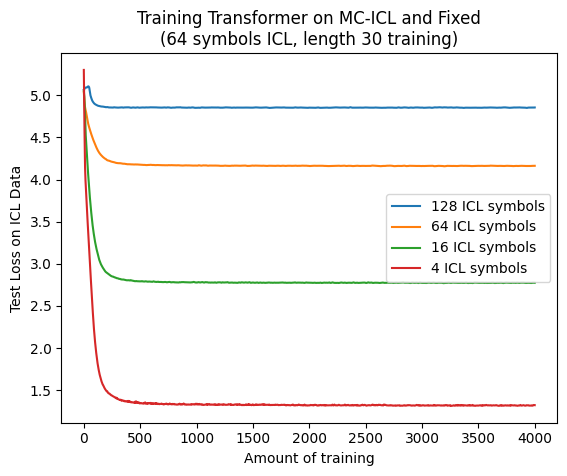

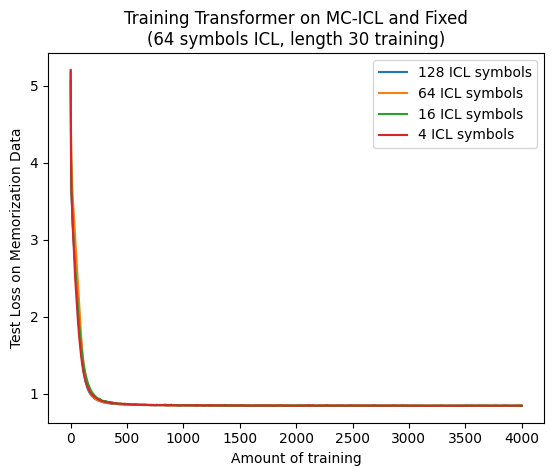

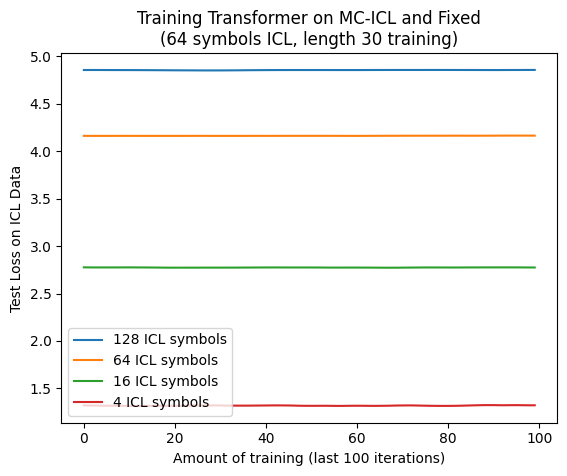

In [42]:
plot_over_options = {"icl_symbol_counts":[icl_symbol_counts, ' ICL symbols'], 
                 "fixed_symbol_counts":[fixed_symbol_counts, ' fixed symbols']} # change just this to change what you plot
counts = plot_over_options[key][0]
legend_str = plot_over_options[key][1]

for i, temp in enumerate(archive):
    accs, fixed_accs, train_loss = temp
    plt.plot(accs, label = str(counts[i])+legend_str)
plt.xlabel("Amount of training")
plt.ylabel("Test Loss on ICL Data")
plt.title(f"Training Transformer on MC-ICL and Fixed\n({num_symbols} symbols ICL, length {length} training)")
plt.title(f"Training Transformer on MC-ICL and Fixed\n({num_symbols} symbols ICL, length {length} training)")
plt.legend()
plt.show()


for i, temp in enumerate(archive):
    accs, fixed_accs, train_loss = temp
    plt.plot(fixed_accs, label = str(counts[i])+legend_str)
plt.xlabel("Amount of training")
plt.ylabel("Test Loss on Memorization Data")
plt.title(f"Training Transformer on MC-ICL and Fixed\n({num_symbols} symbols ICL, length {length} training)")
plt.legend()
plt.show()

for i, temp in enumerate(archive):
    accs, fixed_accs, train_loss = temp
    plt.plot(accs[-100:], label = str(counts[i])+legend_str)
plt.xlabel("Amount of training (last 100 iterations)")
plt.ylabel("Test Loss on ICL Data")
plt.title(f"Training Transformer on MC-ICL and Fixed\n({num_symbols} symbols ICL, length {length} training)")
plt.legend()
plt.show()

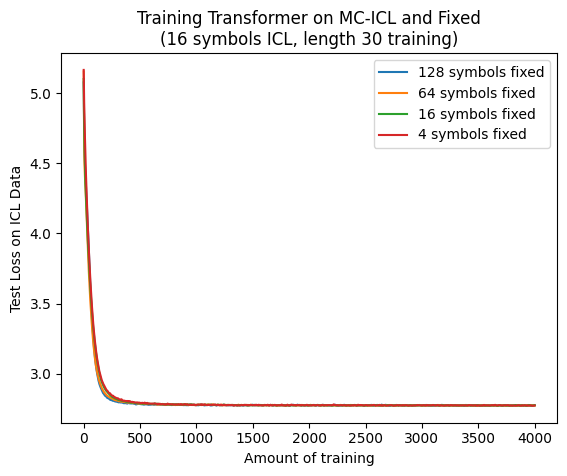

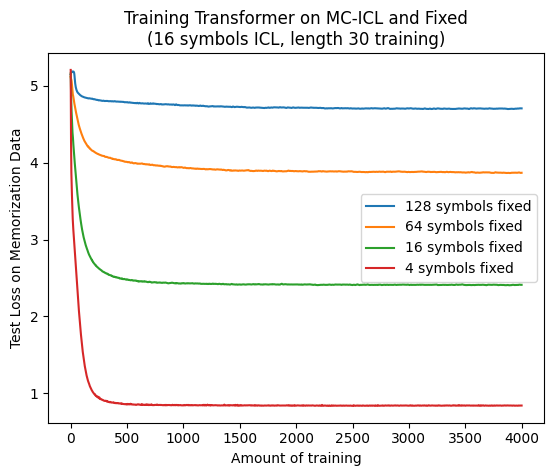

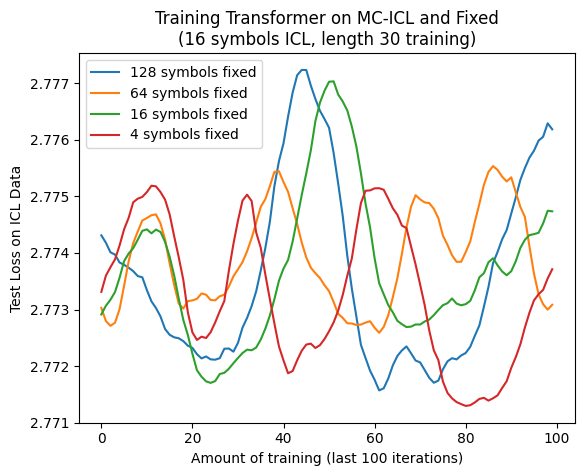

In [23]:
for i, temp in enumerate(archive):
    accs, fixed_accs, train_loss = temp
    plt.plot(accs, label = str(fixed_symbols_list[i])+" symbols fixed")
plt.xlabel("Amount of training")
plt.ylabel("Test Loss on ICL Data")
plt.title(f"Training Transformer on MC-ICL and Fixed\n({num_symbols} symbols ICL, length {length} training)")
plt.legend()
plt.show()


for i, temp in enumerate(archive):
    accs, fixed_accs, train_loss = temp
    plt.plot(fixed_accs, label = str(fixed_symbols_list[i])+" symbols fixed")
plt.xlabel("Amount of training")
plt.ylabel("Test Loss on Memorization Data")
plt.title(f"Training Transformer on MC-ICL and Fixed\n({num_symbols} symbols ICL, length {length} training)")
plt.legend()
plt.show()

for i, temp in enumerate(archive):
    accs, fixed_accs, train_loss = temp
    plt.plot(accs[-100:], label = str(fixed_symbols_list[i])+" symbols fixed")
plt.xlabel("Amount of training (last 100 iterations)")
plt.ylabel("Test Loss on ICL Data")
plt.title(f"Training Transformer on MC-ICL and Fixed\n({num_symbols} symbols ICL, length {length} training)")
plt.legend()
plt.show()

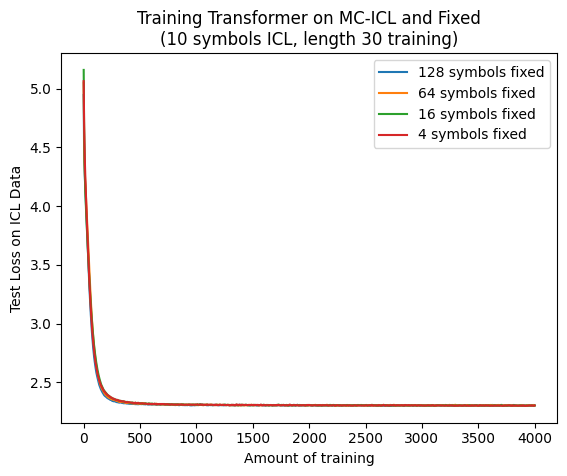

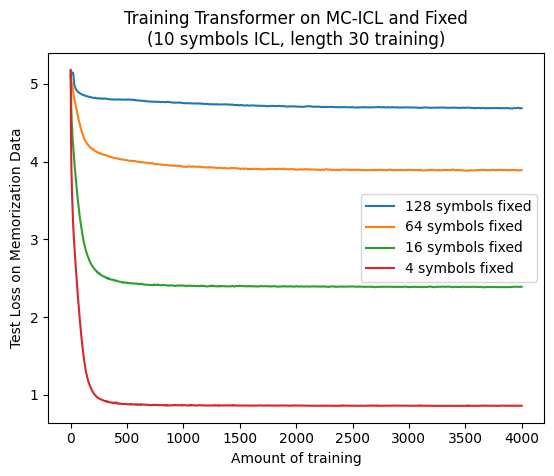

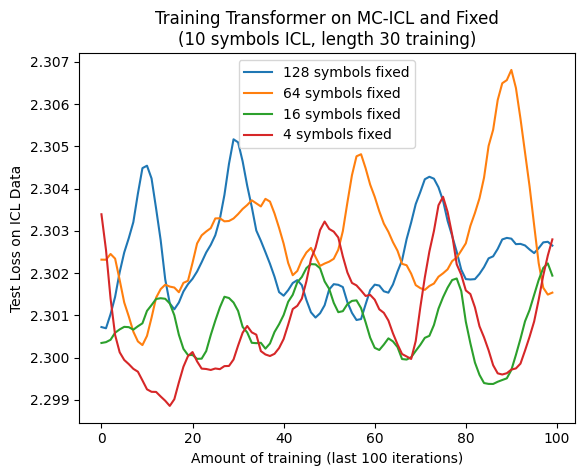

In [11]:
for i, temp in enumerate(archive):
    accs, fixed_accs, train_loss = temp
    plt.plot(accs, label = str(fixed_symbols_list[i])+" symbols fixed")
plt.xlabel("Amount of training")
plt.ylabel("Test Loss on ICL Data")
plt.title(f"Training Transformer on MC-ICL and Fixed\n({num_symbols} symbols ICL, length {length} training)")
plt.legend()
plt.show()


for i, temp in enumerate(archive):
    accs, fixed_accs, train_loss = temp
    plt.plot(fixed_accs, label = str(fixed_symbols_list[i])+" symbols fixed")
plt.xlabel("Amount of training")
plt.ylabel("Test Loss on Memorization Data")
plt.title(f"Training Transformer on MC-ICL and Fixed\n({num_symbols} symbols ICL, length {length} training)")
plt.legend()
plt.show()

for i, temp in enumerate(archive):
    accs, fixed_accs, train_loss = temp
    plt.plot(accs[-100:], label = str(fixed_symbols_list[i])+" symbols fixed")
plt.xlabel("Amount of training (last 100 iterations)")
plt.ylabel("Test Loss on ICL Data")
plt.title(f"Training Transformer on MC-ICL and Fixed\n({num_symbols} symbols ICL, length {length} training)")
plt.legend()
plt.show()

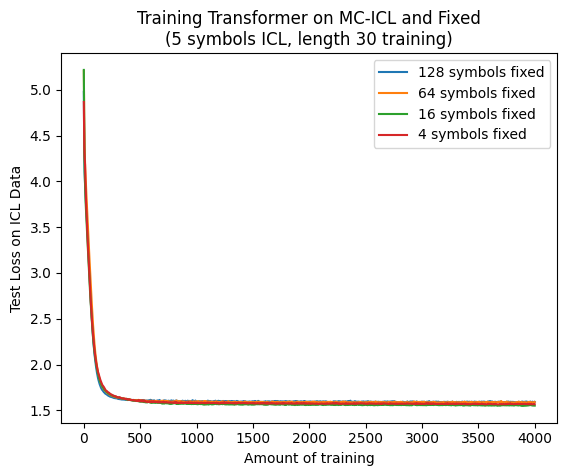

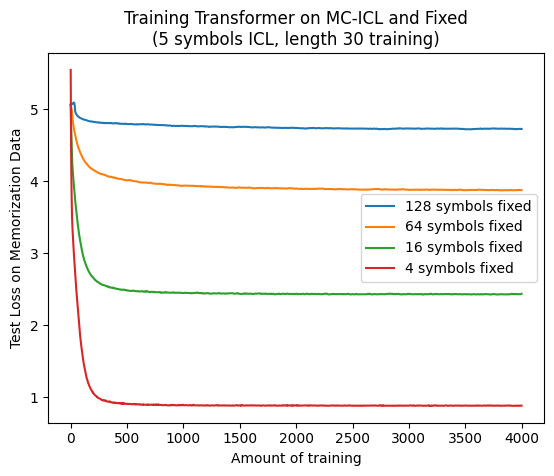

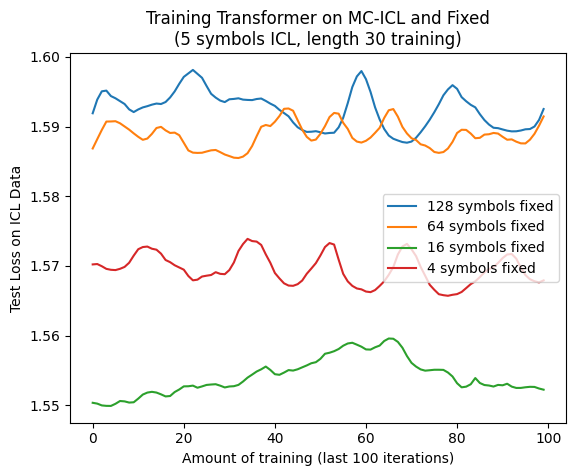

In [9]:
for i, temp in enumerate(archive):
    accs, fixed_accs, train_loss = temp
    plt.plot(accs, label = str(fixed_symbols_list[i])+" symbols fixed")
plt.xlabel("Amount of training")
plt.ylabel("Test Loss on ICL Data")
plt.title(f"Training Transformer on MC-ICL and Fixed\n({num_symbols} symbols ICL, length {length} training)")
plt.legend()
plt.show()


for i, temp in enumerate(archive):
    accs, fixed_accs, train_loss = temp
    plt.plot(fixed_accs, label = str(fixed_symbols_list[i])+" symbols fixed")
plt.xlabel("Amount of training")
plt.ylabel("Test Loss on Memorization Data")
plt.title(f"Training Transformer on MC-ICL and Fixed\n({num_symbols} symbols ICL, length {length} training)")
plt.legend()
plt.show()

for i, temp in enumerate(archive):
    accs, fixed_accs, train_loss = temp
    plt.plot(accs[-100:], label = str(fixed_symbols_list[i])+" symbols fixed")
plt.xlabel("Amount of training (last 100 iterations)")
plt.ylabel("Test Loss on ICL Data")
plt.title(f"Training Transformer on MC-ICL and Fixed\n({num_symbols} symbols ICL, length {length} training)")
plt.legend()
plt.show()

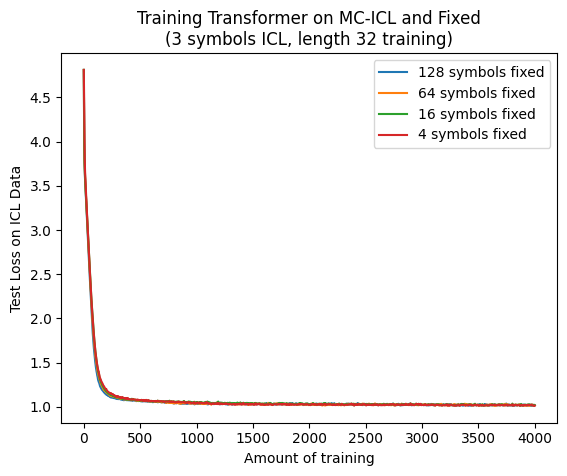

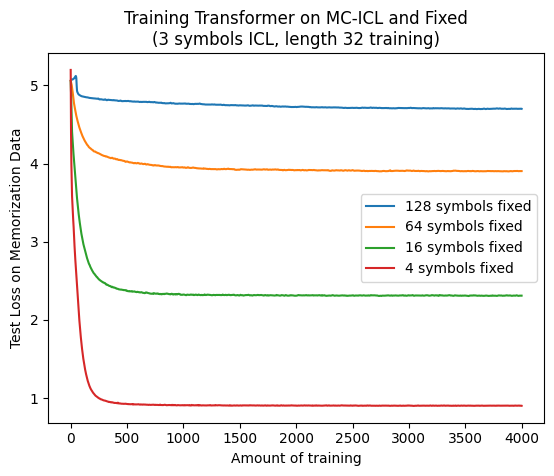

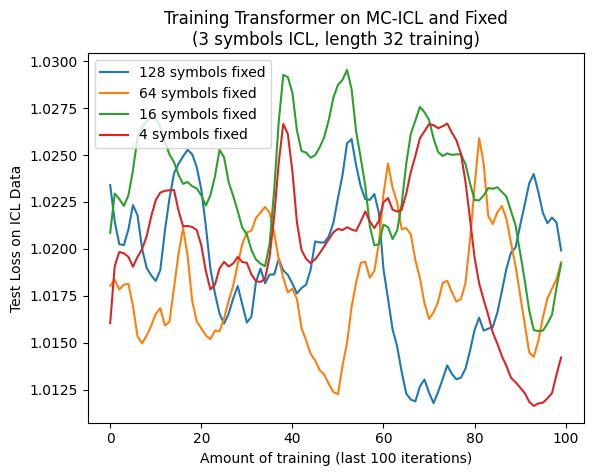

In [ ]:
for i, temp in enumerate(archive):
    accs, fixed_accs, train_loss = temp
    plt.plot(accs, label = str(fixed_symbols_list[i])+" symbols fixed")
plt.xlabel("Amount of training")
plt.ylabel("Test Loss on ICL Data")
plt.title("Training Transformer on MC-ICL and Fixed\n(3 symbols ICL, length 32 training)")
plt.legend()
plt.show()


for i, temp in enumerate(archive):
    accs, fixed_accs, train_loss = temp
    plt.plot(fixed_accs, label = str(fixed_symbols_list[i])+" symbols fixed")
plt.xlabel("Amount of training")
plt.ylabel("Test Loss on Memorization Data")
plt.title("Training Transformer on MC-ICL and Fixed\n(3 symbols ICL, length 32 training)")
plt.legend()
plt.show()

for i, temp in enumerate(archive):
    accs, fixed_accs, train_loss = temp
    plt.plot(accs[-100:], label = str(fixed_symbols_list[i])+" symbols fixed")
plt.xlabel("Amount of training (last 100 iterations)")
plt.ylabel("Test Loss on ICL Data")
plt.title("Training Transformer on MC-ICL and Fixed\n(3 symbols ICL, length 32 training)")
plt.legend()
plt.show()

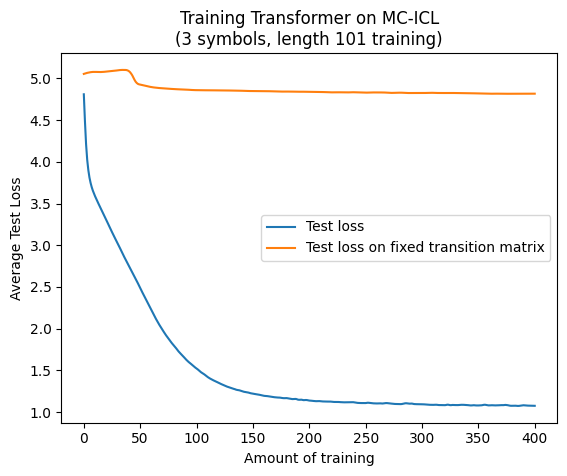

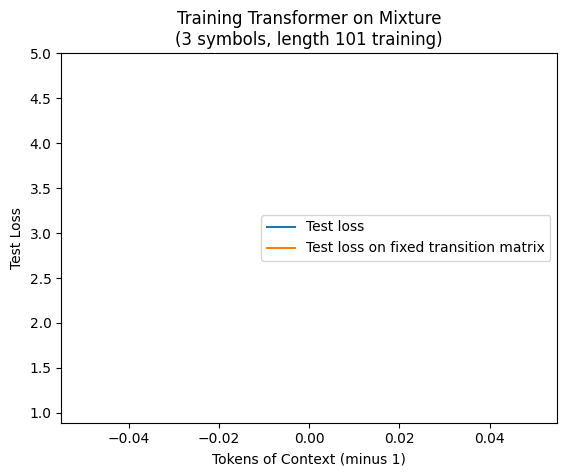

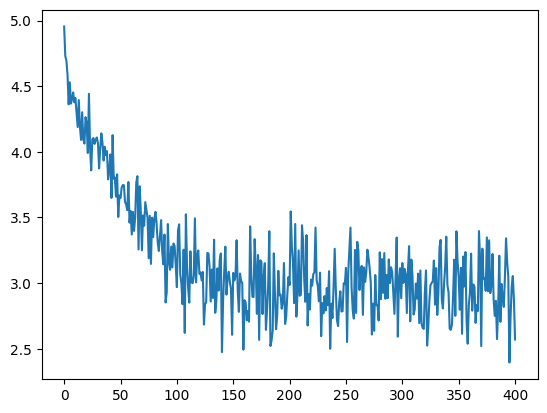

In [ ]:

def plot(results):
    accs, fixed_accs, train_loss = results
    plt.plot(accs, label = "Test loss")
    plt.plot(fixed_accs, label = "Test loss on fixed transition matrix")
    plt.xlabel("Amount of training")
    plt.ylabel("Average Test Loss")
    plt.title("Training Transformer on MC-ICL\n(3 symbols, length 101 training)")
    plt.legend()
    plt.show()
    pos = -1
    plt.plot(accs[-1], label = "Test loss")
    plt.plot(fixed_accs[-1], label = "Test loss on fixed transition matrix")
    plt.xlabel("Tokens of Context (minus 1)")
    plt.ylabel("Test Loss")
    plt.title("Training Transformer on Mixture\n(3 symbols, length 101 training)")
    plt.legend()
    plt.show()
    plt.plot(train_loss)
    plt.show()
plot(archive[-1])
#plot loss at different tokens